# HR-аналитика

Описание проекта:
Компания «Работа с заботой» стремится оптимизировать управление персоналом, минимизировать финансовые потери и снизить отток сотрудников. Для этого HR-аналитики используют данные о сотрудниках, предоставленные бизнесом, и применяют методы машинного обучения для анализа и прогнозирования. Одним из ключевых показателей является уровень удовлетворённости сотрудников, который рассчитывается на основе тест-опросников. Результаты опросов представлены в виде доли удовлетворённости от 0 до 1, где 0 означает полную неудовлетворённость, а 1 — полную удовлетворённость.

Цель проекта:
Построить модель для прогнозирования уровня удовлетворённости сотрудников на основе предоставленных данных.

Разработать модель для предсказания вероятности увольнения сотрудников.

Ход исследования:

Подготовка данных:

- Загрузка и изучение предоставленных датасетов.

- Анализ общей структуры данных, типов переменных и их описания.

Предобработка данных:

- Поиск и обработка пропущенных значений и дубликатов.

- Приведение названий столбцов к единому формату.

- Исследовательский анализ данных:

- Изучение распределений количественных и категориальных признаков.

- Анализ корреляций между признаками для выявления взаимосвязей.

Обучение моделей регрессии:

- Построение и сравнение моделей для прогнозирования уровня удовлетворённости сотрудников.

- Выбор лучшей модели на основе метрики SMAPE (симметричное среднее абсолютное процентное отклонение).

- Обучение моделей классификации:

- Построение и сравнение моделей для прогнозирования оттока сотрудников.

- Выбор лучшей модели на основе метрики ROC-AUC (площадь под ROC-кривой).

Общий вывод:

- Рекомендация лучших моделей машинного обучения для прогнозирования уровня удовлетворённости сотрудников и вероятности их увольнения.

- Предложения по использованию моделей для оптимизации HR-процессов и снижения оттока персонала.

In [1]:
!pip install phik -q
!pip install scikit-learn==1.1.3 -q
!pip install shap -q


<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Полезный ключ **-q** (он "подавит" служебные сообщения об установке, которых может быть достаточно много - вплоть до нескольких экранов прокрутки).
</div>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px

import phik
from phik import resources
from phik.report import plot_correlation_matrix

import sklearn
from sklearn.model_selection import (train_test_split,  
                                     GridSearchCV)

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import (StandardScaler, 
                                   OneHotEncoder, 
                                   OrdinalEncoder,
                                   LabelEncoder,
                                   MinMaxScaler)

from sklearn.metrics import (accuracy_score, 
                             recall_score,
                             precision_score, 
                             roc_auc_score,
                            classification_report,
                            make_scorer)

from sklearn.compose import ColumnTransformer
from scipy import stats as st
from sklearn.impute import SimpleImputer 

import shap

import warnings

In [3]:
RANDOM_STATE = 42

## Загрузка данных

In [4]:
train_job = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
train_job.info()
train_job.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


id        dept   level workload  employment_years last_year_promo  \
0  155278       sales  junior   medium                 2              no   
1  653870          hr  junior     high                 2              no   
2  184592       sales  junior      low                 1              no   
3  171431  technology  junior      low                 4              no   
4  693419          hr  junior   medium                 1              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  
0                   no                      1   24000                   0.58  
1                   no                      5   38400                   0.76  
2                   no                      2   12000                   0.11  
3                   no                      2   18000                   0.37  
4                   no                      3   22800                   0.20

In [5]:
test_features = pd.read_csv('/datasets/test_features.csv')
test_features.info()
test_features.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


id       dept   level workload  employment_years last_year_promo  \
0  485046  marketing  junior   medium                 2              no   
1  686555         hr  junior   medium                 1              no   
2  467458      sales  middle      low                 5              no   
3  418655      sales  middle      low                 6              no   
4  789145         hr  middle   medium                 5              no   

  last_year_violations  supervisor_evaluation  salary  
0                   no                      5   28800  
1                   no                      4   30000  
2                   no                      4   19200  
3                   no                      4   19200  
4                   no                      5   40800

In [6]:
test_target = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
test_target.info()
test_target.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


id  job_satisfaction_rate
0  130604                   0.74
1  825977                   0.75
2  418490                   0.60
3  555320                   0.72
4  826430                   0.08

In [7]:
train_quit = pd.read_csv('/datasets/train_quit.csv')
train_quit.info()
train_quit.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


id        dept   level workload  employment_years last_year_promo  \
0  723290       sales  middle     high                 2              no   
1  814010       sales  junior   medium                 2              no   
2  155091  purchasing  middle   medium                 5              no   
3  257132       sales  junior   medium                 2              no   
4  910140   marketing  junior   medium                 2              no   

  last_year_violations  supervisor_evaluation  salary quit  
0                   no                      4   54000   no  
1                   no                      4   27600   no  
2                   no                      1   37200   no  
3                  yes                      3   24000  yes  
4                   no                      5   25200   no

In [8]:
test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')
test_target_quit.info()
test_target_quit.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


id quit
0  999029  yes
1  372846   no
2  726767   no
3  490105   no
4  416898  yes

- Данные схожи с ТЗ. 
- Названия столбцов не имеет смысла изменять они подходят для работы.
- Есть пропущенные значения, в предобработке устраним.

## Предобработка данных

In [9]:
box_df = [train_job, test_features, test_target, train_quit, test_target_quit]
name_df = ['train_job', 'test_features', 'test_target', 'train_quit', 'test_target_quit']

In [10]:
# Проверка типов данных
for num, df in enumerate(box_df):
    
    print(f'Датафрейм: {name_df[num]}', '\n')
    
    for title in df:
        print(f'Название {title}', df[title].dtype)
    
    print(end='#'*20)
    print('\n')

Датафрейм: train_job 

Название id int64
Название dept object
Название level object
Название workload object
Название employment_years int64
Название last_year_promo object
Название last_year_violations object
Название supervisor_evaluation int64
Название salary int64
Название job_satisfaction_rate float64
####################

Датафрейм: test_features 

Название id int64
Название dept object
Название level object
Название workload object
Название employment_years int64
Название last_year_promo object
Название last_year_violations object
Название supervisor_evaluation int64
Название salary int64
####################

Датафрейм: test_target 

Название id int64
Название job_satisfaction_rate float64
####################

Датафрейм: train_quit 

Название id int64
Название dept object
Название level object
Название workload object
Название employment_years int64
Название last_year_promo object
Название last_year_violations object
Название supervisor_evaluation int64
Название salary int64
Н

In [11]:
# Проверка проверка на уникальные значения
for num, df in enumerate(box_df):
    
    print(f'Датафрейм: {name_df[num]}', '\n')
    
    for title in df:
        if df[title].dtype == 'O': 
            print(f'Уникальные значение {title}', df[title].unique())
    
    print(end='#'*20)
    print('\n')

Датафрейм: train_job 

Уникальные значение dept ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
Уникальные значение level ['junior' 'middle' 'sinior' nan]
Уникальные значение workload ['medium' 'high' 'low']
Уникальные значение last_year_promo ['no' 'yes']
Уникальные значение last_year_violations ['no' 'yes']
####################

Датафрейм: test_features 

Уникальные значение dept ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
Уникальные значение level ['junior' 'middle' 'sinior' nan]
Уникальные значение workload ['medium' 'low' 'high' ' ']
Уникальные значение last_year_promo ['no' 'yes']
Уникальные значение last_year_violations ['no' 'yes']
####################

Датафрейм: test_target 

####################

Датафрейм: train_quit 

Уникальные значение dept ['sales' 'purchasing' 'marketing' 'technology' 'hr']
Уникальные значение level ['middle' 'junior' 'sinior']
Уникальные значение workload ['high' 'medium' 'low']
Уникальные значение last_year_promo ['no' 'yes'

In [12]:
# Проверка проверка на численные значения
for num, df in enumerate(box_df):
    
    print(f'Датафрейм: {name_df[num]}', '\n')
    
    for title in df:
        if (df[title].dtype == 'int' or df[title].dtype == 'float') and title != 'id': 
            print(f'Уникальные значение {title}', df[title].unique(), '\n')
    
    print(end='#'*20)
    print('\n')

Датафрейм: train_job 

Уникальные значение employment_years [ 2  1  4  7  9  6  3 10  8  5] 

Уникальные значение supervisor_evaluation [1 5 2 3 4] 

Уникальные значение salary [24000 38400 12000 18000 22800 30000 56400 52800 13200 54000 19200 40800
 34800 27600 26400 33600 50400 15600 14400 25200 72000 31200 32400 48000
 43200 46800 58800 84000 44400 39600 37200 21600 28800 62400 60000 42000
 49200 55200 57600 68400 45600 51600 64800 80400 20400 61200 76800 69600
 16800 36000 63600 81600 66000 74400 67200 70800 73200 75600 79200 94800
 78000 88800 92400 85200 91200 98400 96000 97200] 

Уникальные значение job_satisfaction_rate [0.58 0.76 0.11 0.37 0.2  0.78 0.56 0.44 0.14 0.47 0.74 0.42 0.32 0.57
 0.16 0.69 0.33 0.64 0.39 0.8  0.79 0.17 0.65 0.18 0.19 0.49 0.63 0.22
 0.23 0.5  0.35 0.3  0.77 0.88 0.59 0.21 0.36 0.85 0.7  0.48 0.6  0.1
 0.27 0.71 0.86 0.54 0.73 0.46 0.31 0.72 0.51 0.61 0.81 0.99 0.15 0.91
 0.68 0.4  0.89 0.67 0.75 0.98 0.26 0.45 0.92 0.82 0.66 0.55 0.38 0.53
 0.84 0.52

In [13]:
# Проверка проверка на дубликаты
for num, df in enumerate(box_df):
    print(f'Датафрейм: {name_df[num]}', '\n')
    print('Где присутсвуют дубликаты', df[df.duplicated(keep=False)], '\n')
    
    print(end='#'*20)
    print('\n')

Датафрейм: train_job 

Где присутсвуют дубликаты Empty DataFrame
Columns: [id, dept, level, workload, employment_years, last_year_promo, last_year_violations, supervisor_evaluation, salary, job_satisfaction_rate]
Index: [] 

####################

Датафрейм: test_features 

Где присутсвуют дубликаты Empty DataFrame
Columns: [id, dept, level, workload, employment_years, last_year_promo, last_year_violations, supervisor_evaluation, salary]
Index: [] 

####################

Датафрейм: test_target 

Где присутсвуют дубликаты Empty DataFrame
Columns: [id, job_satisfaction_rate]
Index: [] 

####################

Датафрейм: train_quit 

Где присутсвуют дубликаты Empty DataFrame
Columns: [id, dept, level, workload, employment_years, last_year_promo, last_year_violations, supervisor_evaluation, salary, quit]
Index: [] 

####################

Датафрейм: test_target_quit 

Где присутсвуют дубликаты Empty DataFrame
Columns: [id, quit]
Index: [] 

####################



In [ ]:
for num, df in enumerate(box_df):
    print(f'Датафрейм: {name_df[num]}', '\n')
    print('Где присутсвуют nan \n', df.isnull().sum(), '\n')
    
    print(end='#'*20)
    print('\n')

Датафрейм: train_job 

Где присутсвуют nan 
 id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64 

####################

Датафрейм: test_features 

Где присутсвуют nan 
 id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64 

####################

Датафрейм: test_target 

Где присутсвуют nan 
 id                       0
job_satisfaction_rate    0
dtype: int64 

####################

Датафрейм: train_quit 

Где присутсвуют nan 
 id                       0
dept                     0
level                    0
workload                 0
employment_years         0


In [15]:
# Вывод где nan
for num, df in enumerate(box_df):
    print(f'Датафрейм: {name_df[num]}', '\n')
    print('Где присутсвуют nan \n', df[df.isna().any(axis=1)], '\n')
    
    print(end='#'*20)
    print('\n')

Датафрейм: train_job 

Где присутсвуют nan 
           id   dept   level workload  employment_years last_year_promo  \
1209  631073  sales     NaN   medium                 1              no   
1469  416327  sales     NaN      low                 1              no   
1526  694746    NaN  junior   medium                 5              no   
1630  814624    NaN  junior   medium                 3              no   
1633  475114    NaN  junior     high                 4              no   
1745  135043  sales     NaN   medium                 1              no   
2522  998838  sales     NaN   medium                 1              no   
2781  497243    NaN  junior   medium                 1              no   
2975  168668    NaN  junior      low                 3              no   
3866  641150    NaN  junior      low                 3              no   

     last_year_violations  supervisor_evaluation  salary  \
1209                   no                      4   27600   
1469                

## Исследовательский анализ данных

# Задача 1: предсказание уровня удовлетворённости сотрудника

# Тренировочная выборка

In [17]:
def func_hist(df, name):
    df[name].hist(figsize = (6, 4), bins=50)
    
    plt.title(name)
    plt.xlabel(f'Количество {name}')
    plt.ylabel('Частота')
    
    plt.show();

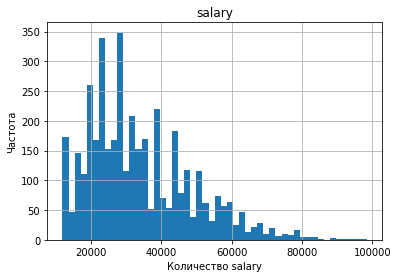

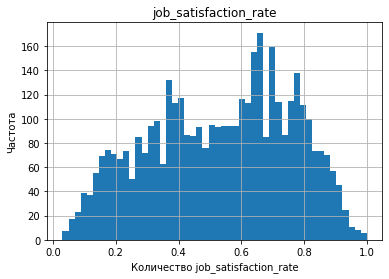

In [18]:
box = ['salary', 'job_satisfaction_rate']

for name in box:
    func_hist(df=train_job, name=name)

In [19]:
def func_count(df, name):
    plt.figure(figsize=(6, 4))
    
    sns.countplot(data=df,  x=name, palette='Set1')
    
    plt.title(name)
    plt.xlabel(f'Количество {name}')
    plt.ylabel('Частота')
    
    plt.grid(True)
    plt.show();

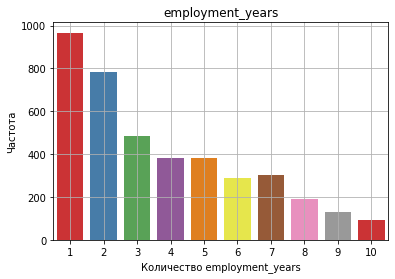

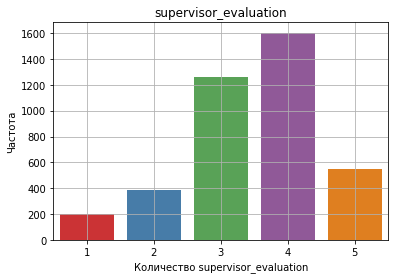

In [20]:
box = ['employment_years', 'supervisor_evaluation']

for name in box:
    func_count(df=train_job, name=name)

In [21]:
train_job.describe().T

count           mean            std        min  \
id                     4000.0  544957.621000  257883.104622  100954.00   
employment_years       4000.0       3.718500       2.542513       1.00   
supervisor_evaluation  4000.0       3.476500       1.008812       1.00   
salary                 4000.0   33926.700000   14900.703838   12000.00   
job_satisfaction_rate  4000.0       0.533995       0.225327       0.03   

                             25%        50%        75%       max  
id                     322836.75  534082.50  771446.00  999521.0  
employment_years            2.00       3.00       6.00      10.0  
supervisor_evaluation       3.00       4.00       4.00       5.0  
salary                  22800.00   30000.00   43200.00   98400.0  
job_satisfaction_rate       0.36       0.56       0.71       1.0

Для этой задачи заказчик предоставил данные с признаками:
* id — уникальный идентификатор сотрудника;
* dept — отдел, в котором работает сотрудник;
* level — уровень занимаемой должности;
* workload — уровень загруженности сотрудника;
* employment_years — длительность работы в компании (в годах);
* last_year_promo — показывает, было ли повышение за последний год;
* last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
* supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
* salary — ежемесячная зарплата сотрудника;
* job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

In [22]:
conditions = [(train_job['job_satisfaction_rate'] < 0.3), (train_job['job_satisfaction_rate'] >= 0.3) & (train_job['job_satisfaction_rate'] < 0.7),(train_job['job_satisfaction_rate'] >= 0.7)]

choices = ['Неудовлетворенность', 'Среднее', 'Удовлетворенное']

train_job['mood'] = np.select(conditions, choices, default='Неизвестно')

In [23]:
def graf_job(df, hue, x, num):
    sns.set_style('white')
    count = 10
    box = ['длительность']
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    if num == 1:
        sns.countplot(data=df, hue=hue, x=x, palette='Set1', ax=axes[0])
    else:
        sns.barplot(data=df, x=hue, y=x, palette='Set1', ax=axes[0])
        
    axes[0].set_title(f'Распределени от {x}', fontsize=count, fontweight="normal", color='black')
    axes[0].set_xlabel('Значение', fontsize=count, fontweight="normal", color='black')
    axes[0].set_ylabel('Частота', fontsize=count, fontweight="normal", color='black')
    axes[0].grid(color='black', linewidth=1, alpha=0.3)
    
    sns.boxplot(data=df, x=hue, y=x, ax=axes[1], palette='Set1')
    axes[1].set_title(f'Распределени от от {x}', fontsize=count, fontweight="normal", color='black')
    axes[1].set_xlabel('Частота', fontsize=count, fontweight="normal", color='black')
    axes[1].set_ylabel('Разрбос', fontsize=count, fontweight="normal", color='black')
    axes[1].grid(color='black', linewidth=1, alpha=0.3)
    
    plt.tight_layout()
    plt.show();    
    

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Отлично! Красивая функция. Ну и здорово что ты понимаешь, что применение функций упрощает код, делает его структурированным, простым для понимания и упрощает его дальнейшее переиспользование (принцип DRY (Don’t Repeat Yourself / Не повторяйся) – в действии). Дополнительно о DRY можно почитать здесь: https://habr.com/ru/company/itelma/blog/546372


</div>

In [24]:
box_discrete = ['employment_years', 'supervisor_evaluation']
box_continuously = ['salary', 'job_satisfaction_rate']
box_categorical = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'mood']

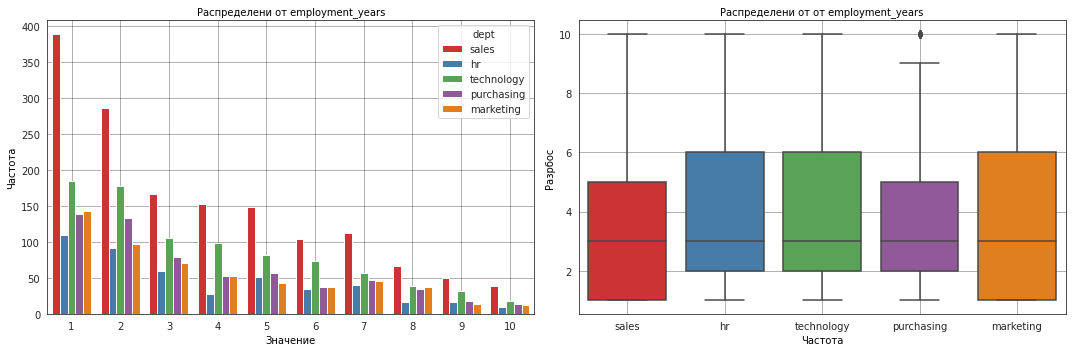

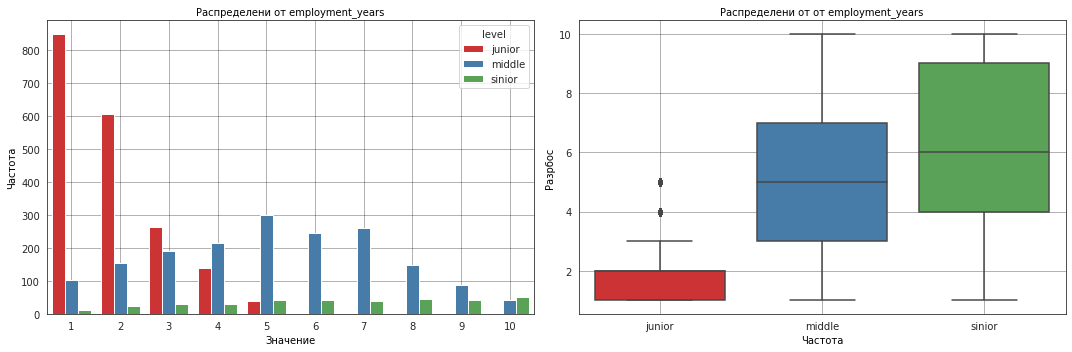

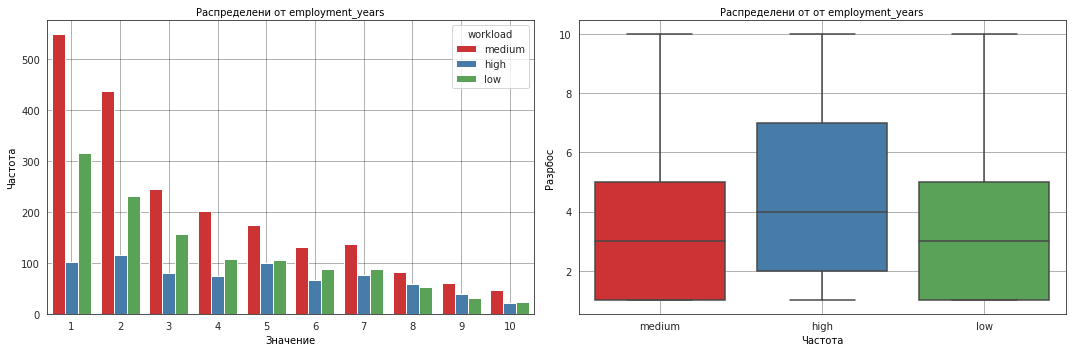

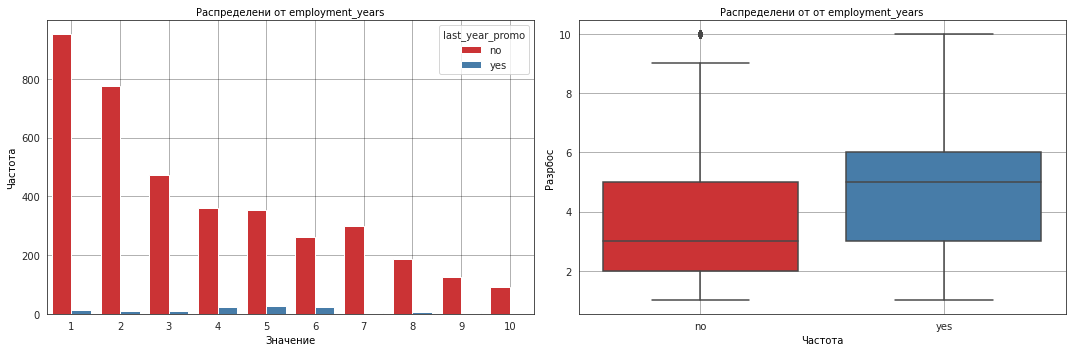

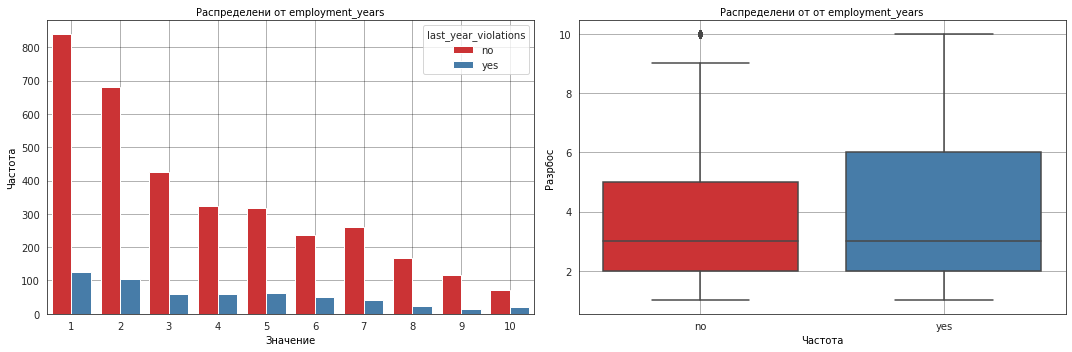

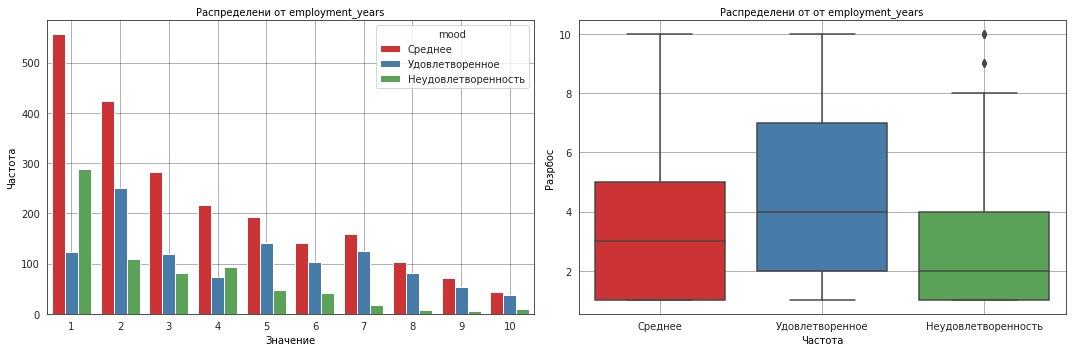

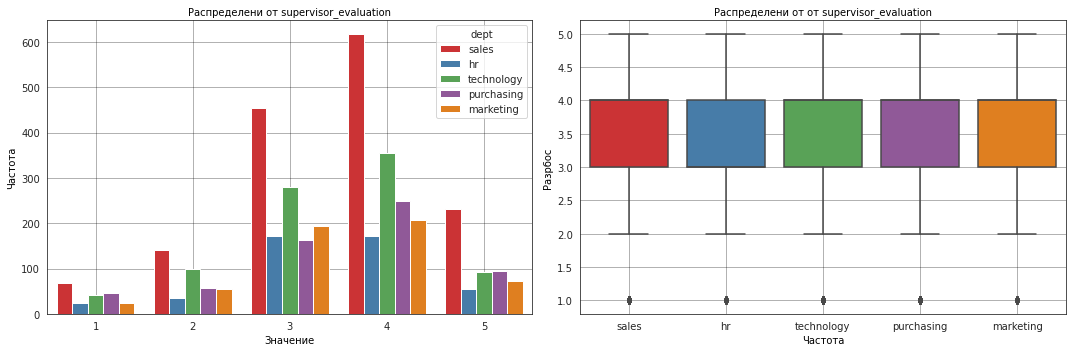

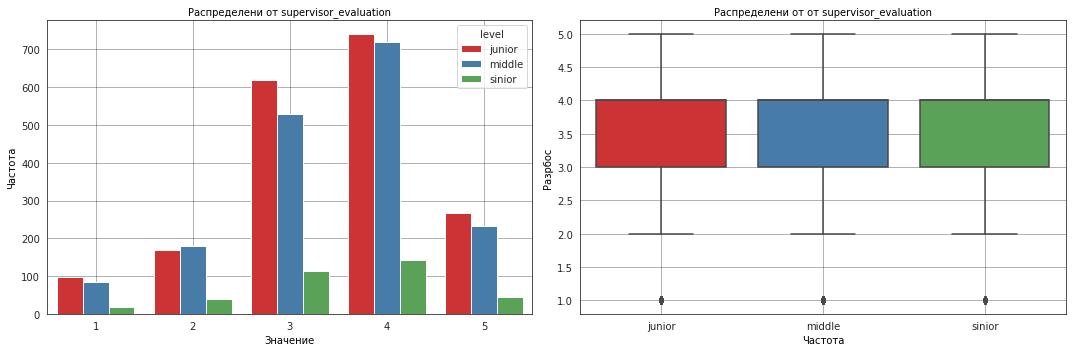

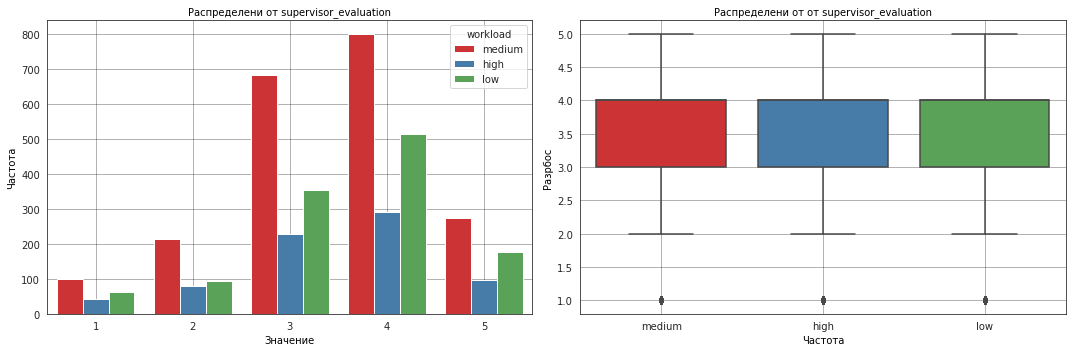

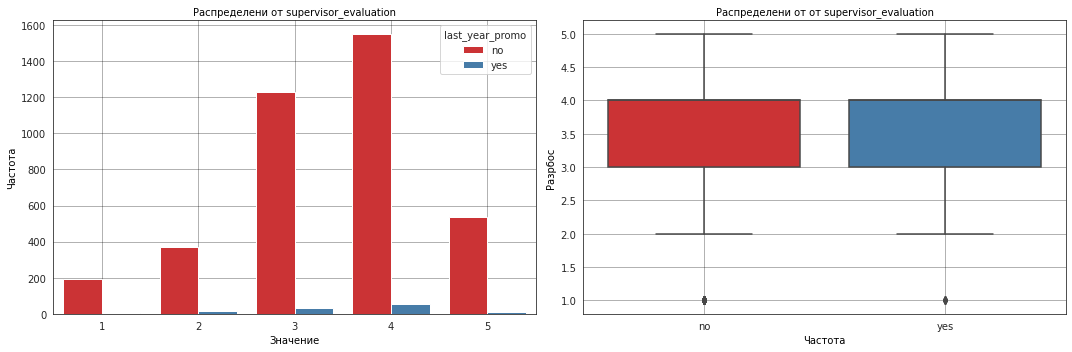

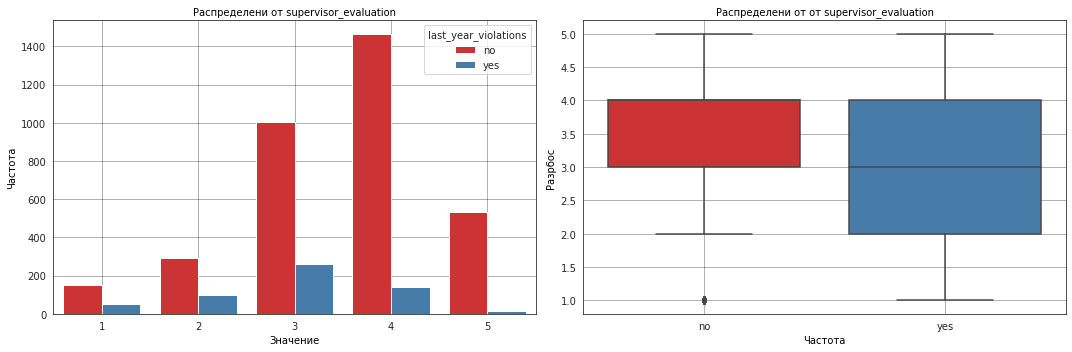

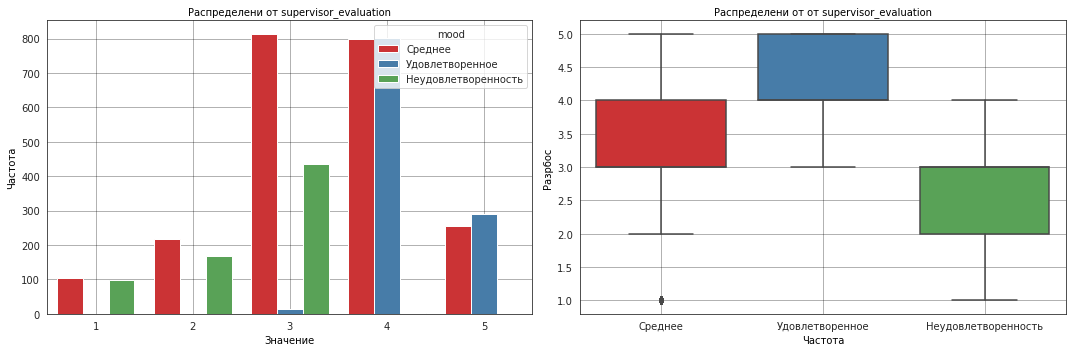

In [25]:
for dis in box_discrete:
    for cat in box_categorical:
        graf_job(df=train_job, hue=cat, x=dis, num=1)

- Можно заметить на графике длительность работы от професии, большинство hr не задерживаются дольше трех лет.
- Sales работает больше всего они работают до 5 лет.
- У остальных одинаковая тенденция до 5 лет снижение, а потом некоторе плато.

- В редких случаях джуниоры работают до 5 лет без повышения.
- В первый три года работы либо средний уровень нагруженности или низкий, большинство отметили, что у них средний уровень нагруженности. После трех лет нагруженность работы возрастает.

- По нарушениям правил можно заметить, что не нарушают большинство в первые три кода, возможно это связано с боязню потерять работу. Люди нарушают правило с увеличением рабочего опыта чаще, потому что людей с опыт работы более трех лет меньше становится, а нарушений нет.

- Как и ожидалось, те кто доволен работой остаются на ней более трех лет.
- Остальные увольяются в первые три года, потом видно, что недовольствие снижается.

- Распределение оценок от категории работы у всех распределен одинаково. Нужно учитывать, что sale больше всех и поэтому кажется, что выбивается.
- От должности тоже все равномерно, только возможно sinior реже ругаются.
- Из интересного можно заметить, что кто имеет высокие оценки 4 и 5, имеют высокое настроение.


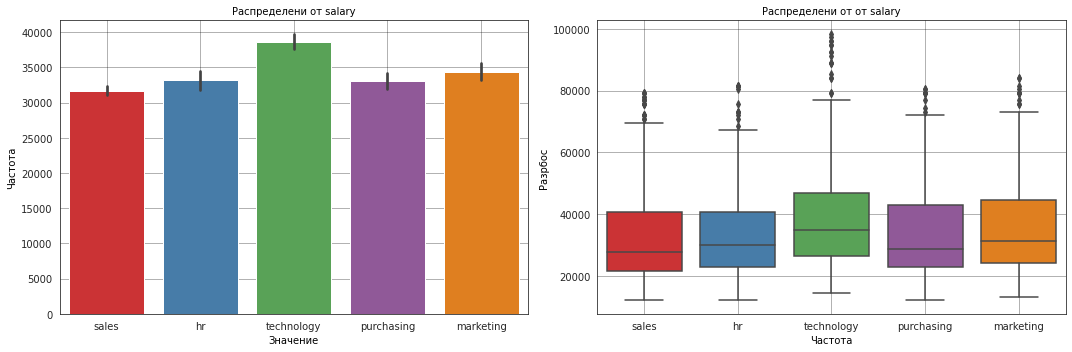

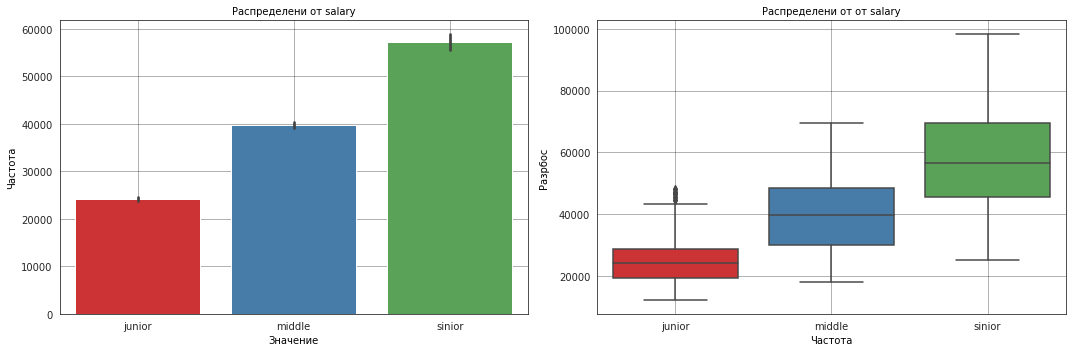

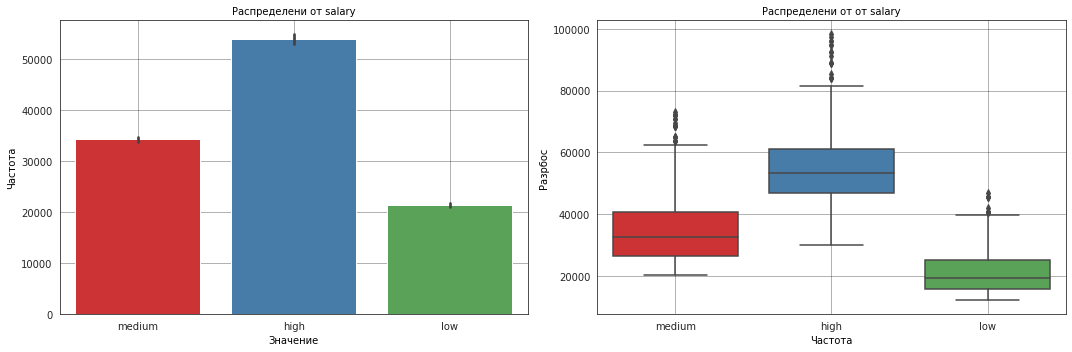

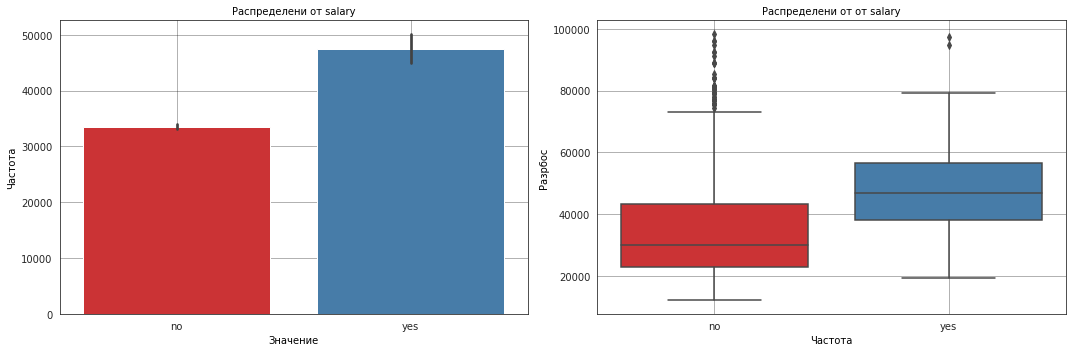

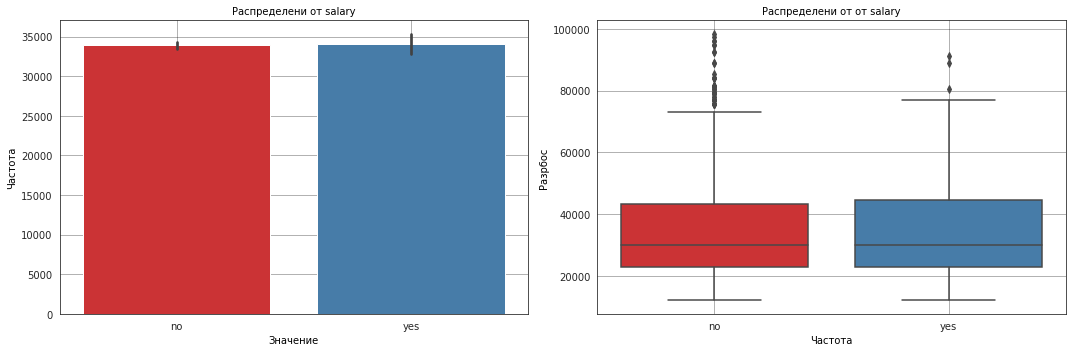

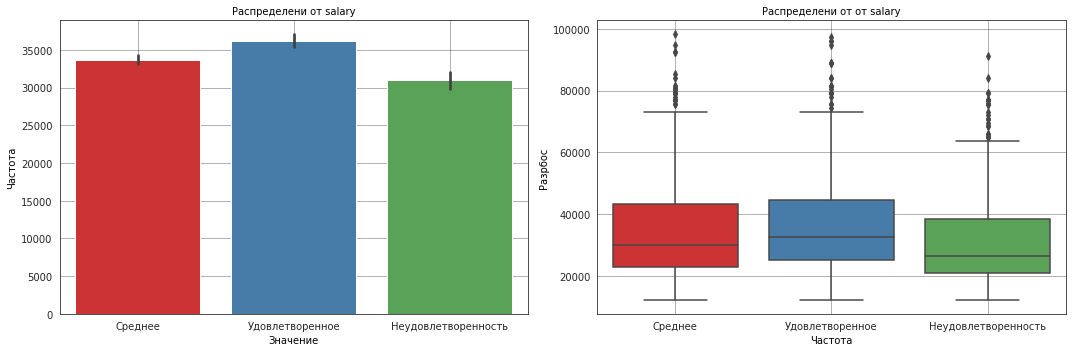

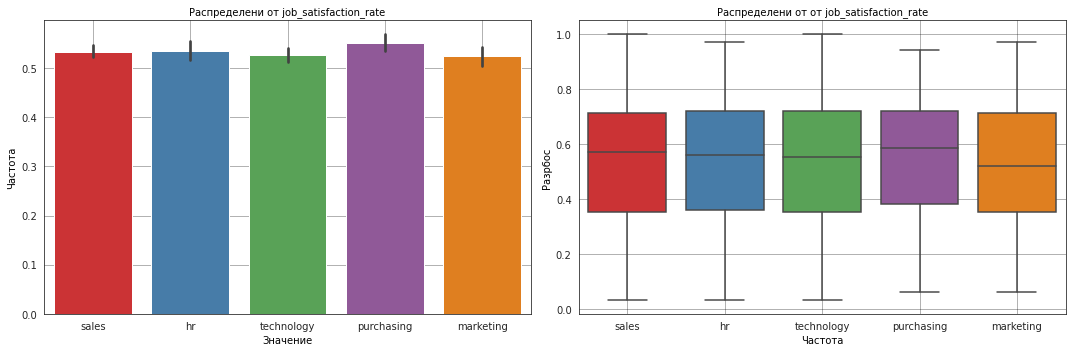

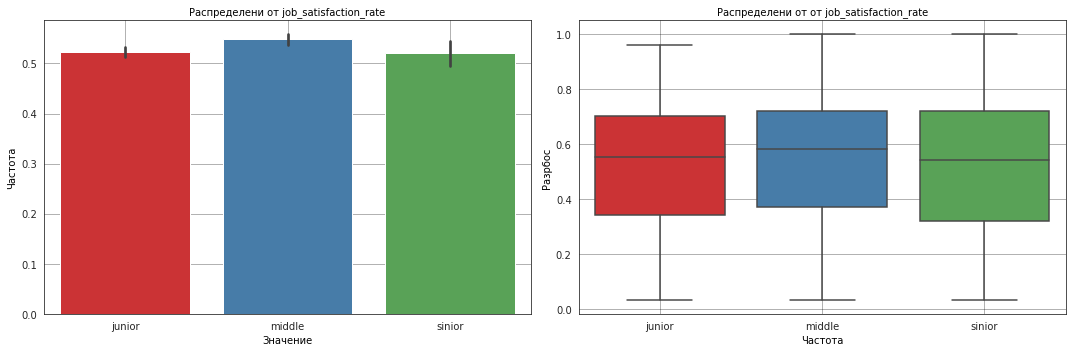

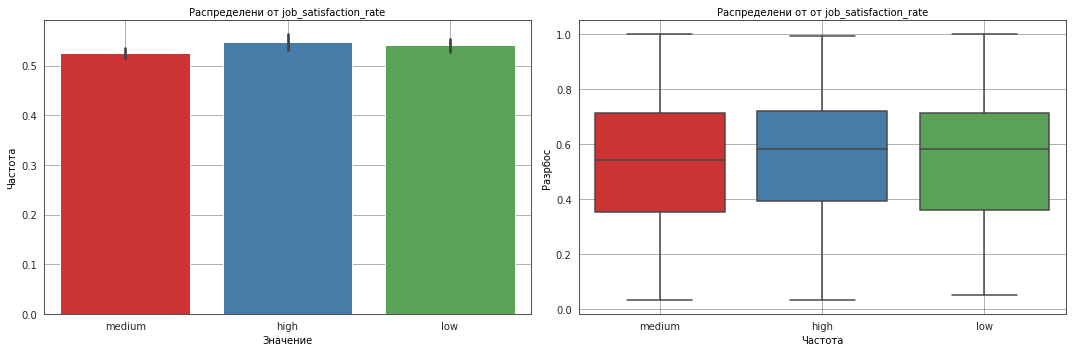

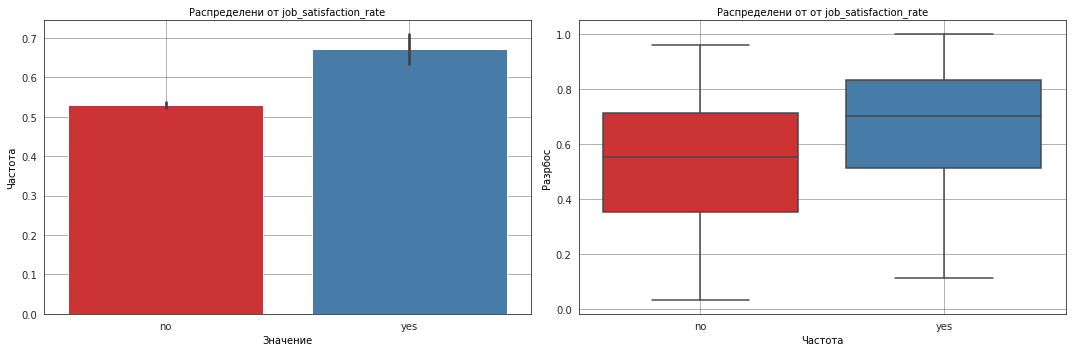

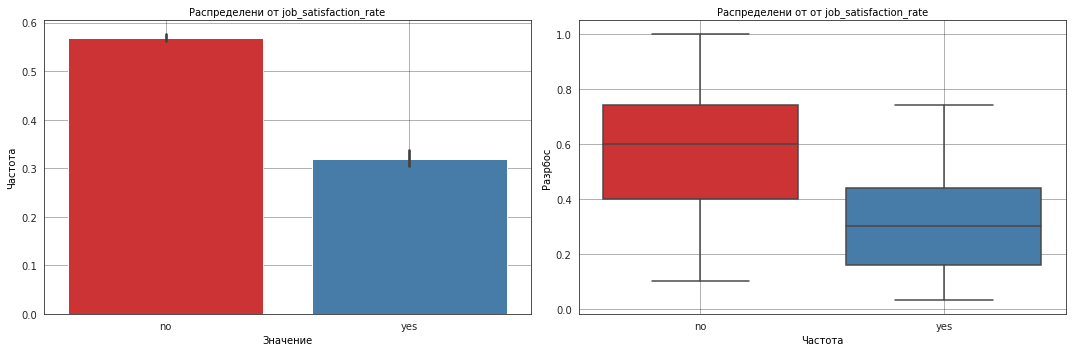

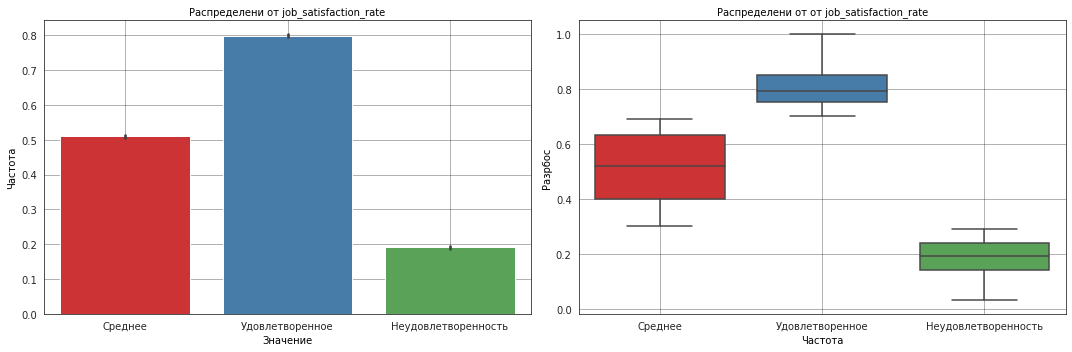

In [26]:
for dis in box_continuously:
    for cat in box_categorical:
        graf_job(df=train_job, hue=cat, x=dis, num=0)

- По зарплате можно заметить, что больше всех в професии зарабатывают technology. У них можно заметить, что зарплата, чаще всего выбивается.
- Sinior получают больше всего.
- Видно что зарплата зависит от нагруженности, чем больше работы, тем больше зарплата.
- При повышении в должности, выростает зарплата, а вот зарплата от правонарушений не зависит.
- На настроение не было видно зависимости зарплаты.


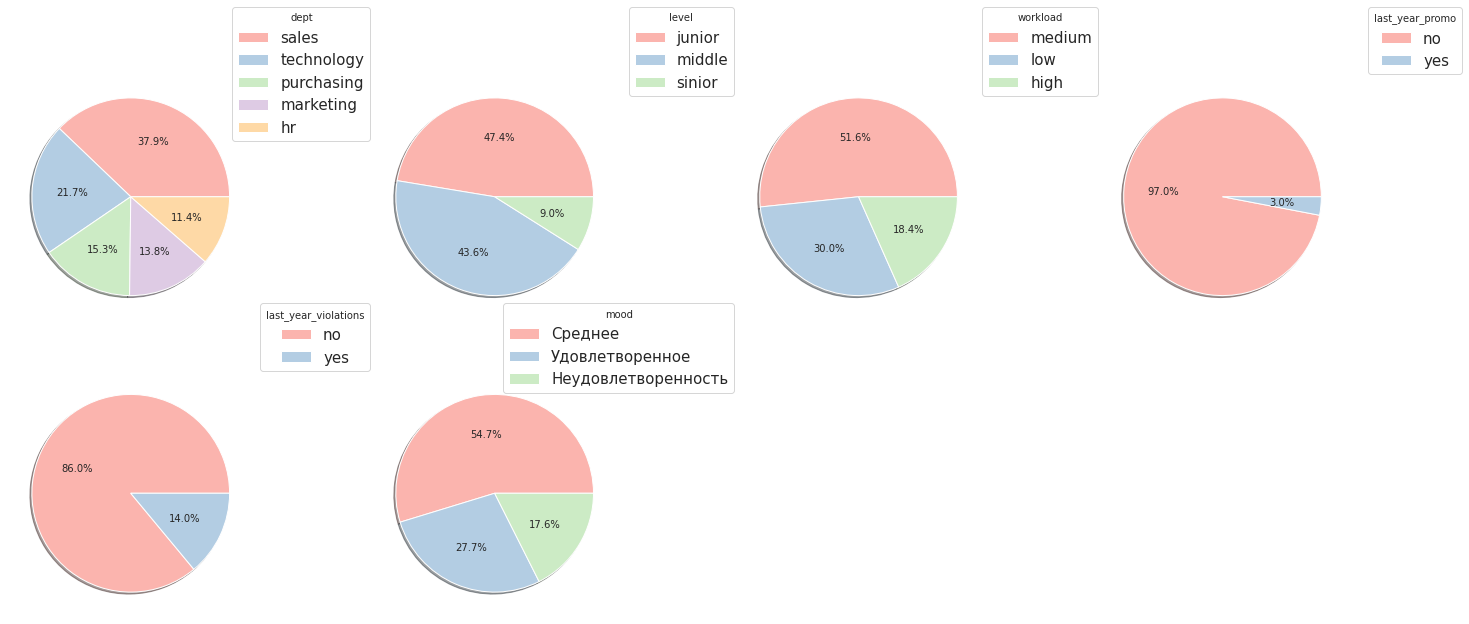

In [27]:
def graf_pie(df, lis, i):
    count=15
    box = df[lis].value_counts()
    
    plt.subplot(2, 4, i + 1)
    
    colors = sns.color_palette('Pastel1', len(box))
    plt.pie(x=box, autopct='%1.1f%%', shadow=True, colors=colors)
    plt.legend(box.index, title=lis, loc='upper right', bbox_to_anchor=(1.5, 1.3), fontsize=count)
   

box = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'mood']

i = 0

plt.figure(figsize=(25, 10))

for name in box:
    graf_pie(df=train_job, lis=name,  i=i)
    i += 1

In [28]:
box_df = train_job

box_df['dept'] = box_df['dept'].fillna('sales')
box_df['level'] = box_df['level'].fillna('middle')

In [29]:
fig = px.sunburst(box_df, 
                  path=['dept', 'level', 'workload'],
                  values='salary',
                  title='График разбивка по специальности и уровню',
                  #color='job_satisfaction_rate',
                  color_continuous_scale='RdBu'
                 )

fig.show()

In [30]:
fig = px.sunburst(box_df, 
                  path=['dept', 'level', 'last_year_promo'],
                  values='salary',
                  title='График разбивка по специальности и уровню счастья от повышения',
                  color='job_satisfaction_rate',
                  color_continuous_scale='RdBu'
                 )

fig.show()

In [31]:
fig = px.sunburst(box_df, 
                  path=['dept', 'level', 'workload'],
                  values='salary',
                  title='График разбивка по загруженности от специальности и уровню счастья',
                  color='job_satisfaction_rate',
                  color_continuous_scale='RdBu'
                 )

fig.show()

In [32]:
fig = px.sunburst(box_df, 
                  path=['dept', 'level', 'last_year_violations'],
                  values='salary',
                  title='График разбивка по специальности и уровню счастья',
                  color='job_satisfaction_rate',
                  color_continuous_scale='RdBu'
                 )

fig.show()

- Можно заметить на графике длительность работы от професии, большинство hr не задерживаются дольше трех лет.
- Sales работает больше всего они работают до 5 лет.
- У остальных одинаковая тенденция до 5 лет снижение, а потом некоторе плато.

- В редких случаях джуниоры работают до 5 лет без повышения.
- В первый три года работы либо средний уровень нагруженности или низкий, большинство отметили, что у них средний уровень нагруженности. После трех лет нагруженность работы возрастает.

- По нарушениям правил можно заметить, что не нарушают большинство в первые три кода, возможно это связано с боязню потерять работу. Люди нарушают правило с увеличением рабочего опыта чаще, потому что людей с опыт работы более трех лет меньше становится, а нарушений нет.

- Как и ожидалось, те кто доволен работой остаются на ней более трех лет.
- Остальные увольяются в первые три года, потом видно, что недовольствие снижается.

- Распределение оценок от категории работы у всех распределен одинаково. Нужно учитывать, что sale больше всех и поэтому кажется, что выбивается.
- От должности тоже все равномерно, только возможно sinior реже ругаются.
- Из интересного можно заметить, что кто имеет высокие оценки 4 и 5, имеют высокое настроение.

- По зарплате можно заметить, что больше всех в професии зарабатывают technology. У них можно заметить, что зарплата, чаще всего выбивается.
- Sinior получают больше всего.
- Видно что зарплата зависит от нагруженности, чем больше работы, тем больше зарплата.
- При повышении в должности, выростает зарплата, а вот зарплата от правонарушений не зависит.
- На настроение не было видно зависимости зарплаты.

Мини вывод: 

- Можно заметить, что большинство удовлетворены работой.
- Повышение в должности повышает настроение работника.
- Те кто не нарушают правила на работе, удовлетворены работой. Я думаю, те кто нарушают, уже не боятся уволнения.
- От уровня сложности страдают маркетинг и hr на начальных позициях. Там сильнее всего заметно, уровень счастья от кол-во работы и професии.
- На удовлетворенность не замечена влияние зарплаты.
- И здесь спорный момент, тех кого хвалят начальство удовлетворены профессий или им нравится сама работа или им нравится похвала начальства.

# Входные признаки тестовой выборки

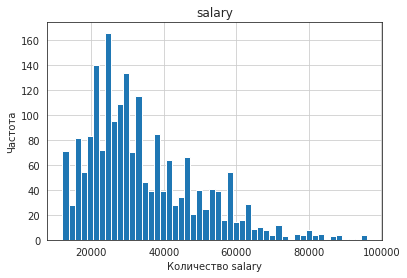

In [33]:
box = ['salary']

for name in box:
    func_hist(df=test_features, name=name)

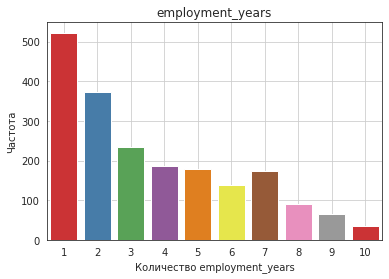

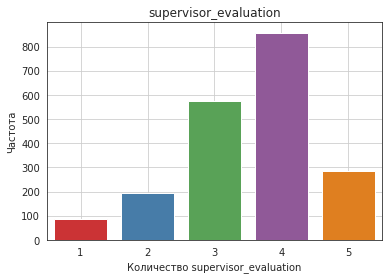

In [34]:
box = ['employment_years', 'supervisor_evaluation']

for name in box:
    func_count(df=test_features, name=name)

In [36]:
test_features.describe().T

count         mean            std       min       25%  \
id                     2000.0  552765.2135  253851.326129  100298.0  339052.0   
employment_years       2000.0       3.6665       2.537222       1.0       1.0   
supervisor_evaluation  2000.0       3.5265       0.996892       1.0       3.0   
salary                 2000.0   34066.8000   15398.436729   12000.0   22800.0   

                            50%        75%       max  
id                     550793.0  765763.75  999029.0  
employment_years            3.0       6.00      10.0  
supervisor_evaluation       4.0       4.00       5.0  
salary                  30000.0   43200.00   96000.0

In [37]:
box_discrete = ['employment_years', 'supervisor_evaluation']
box_continuously = ['salary']
box_categorical = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

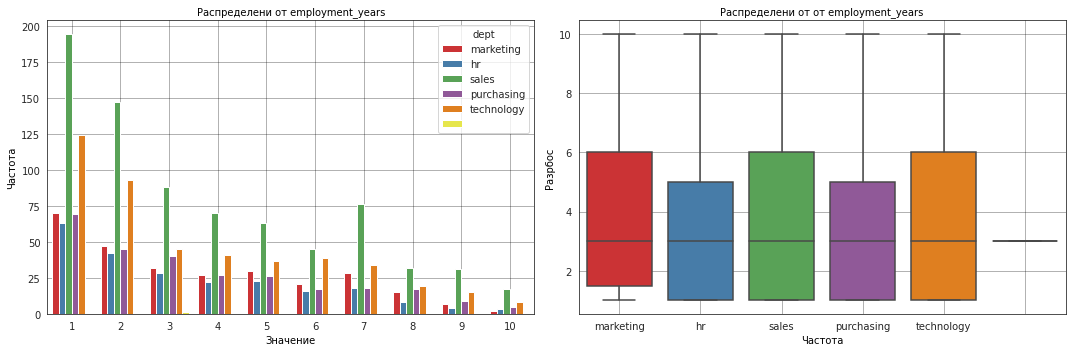

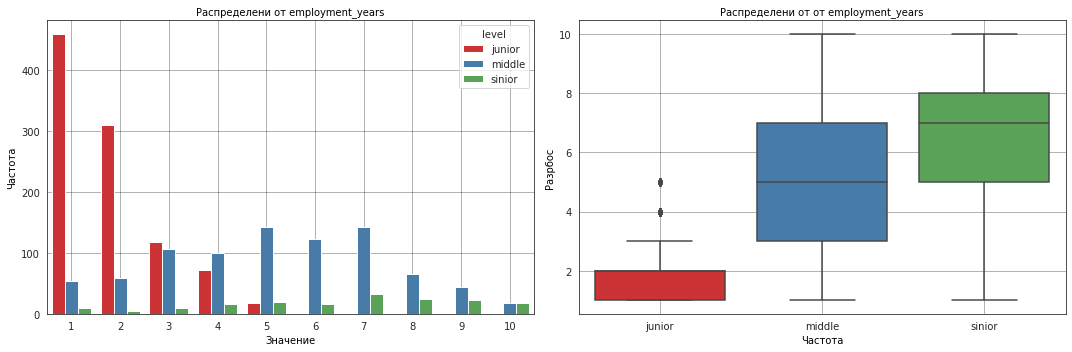

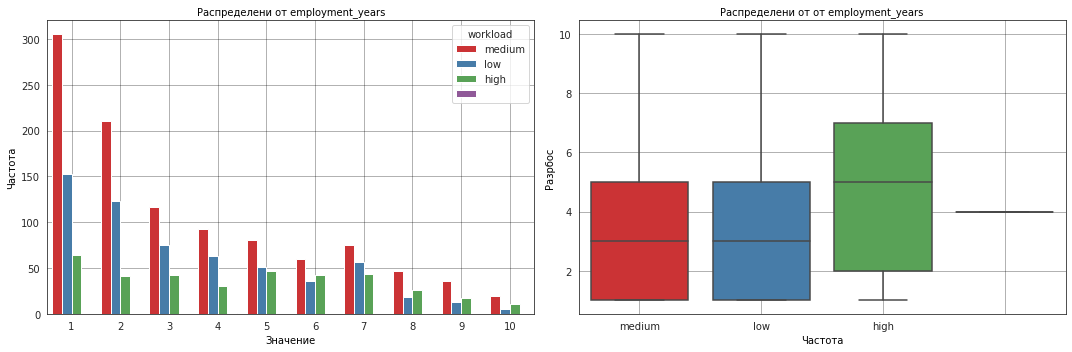

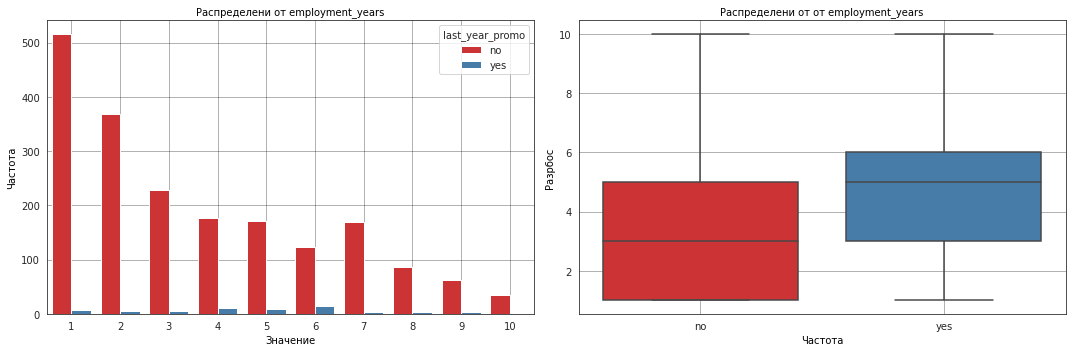

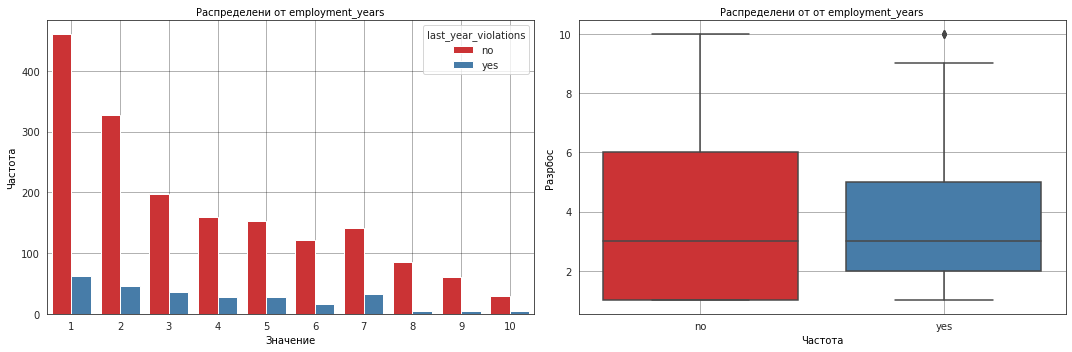

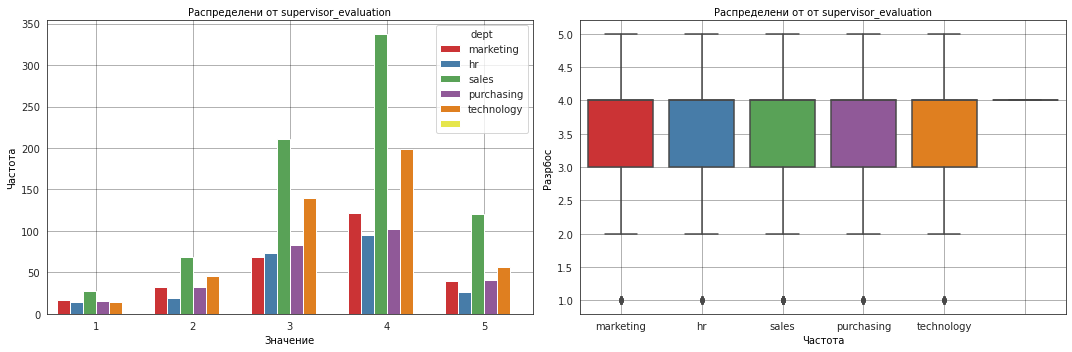

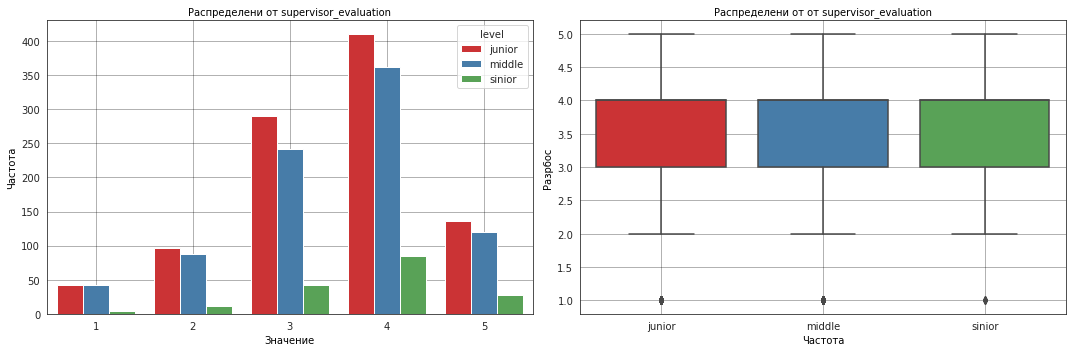

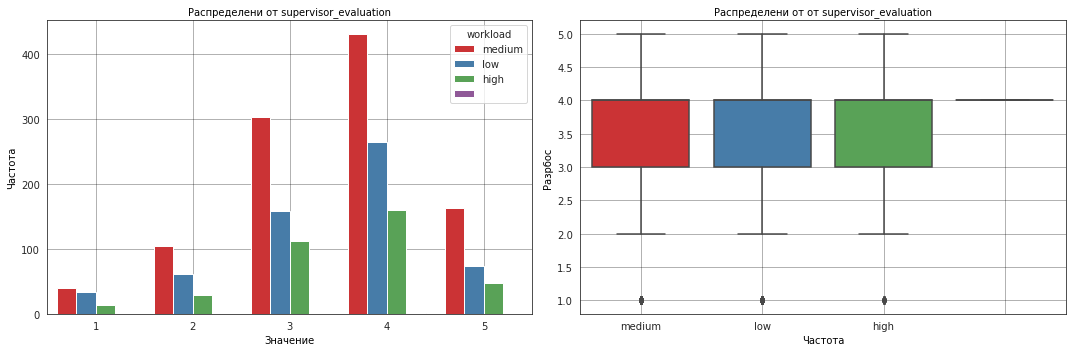

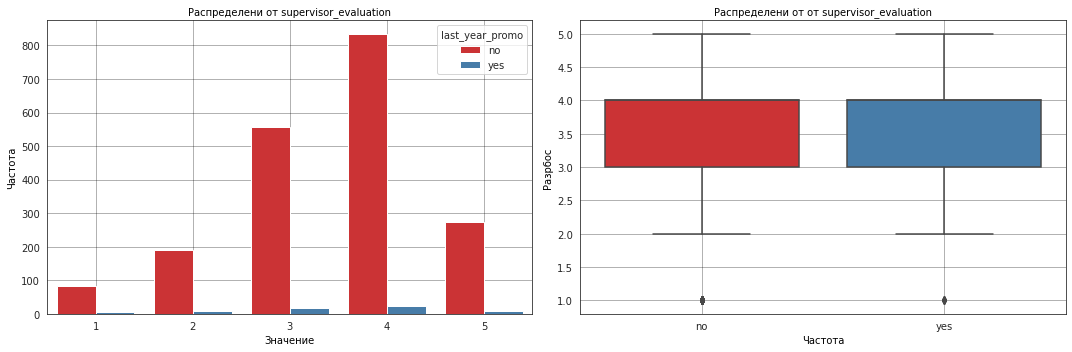

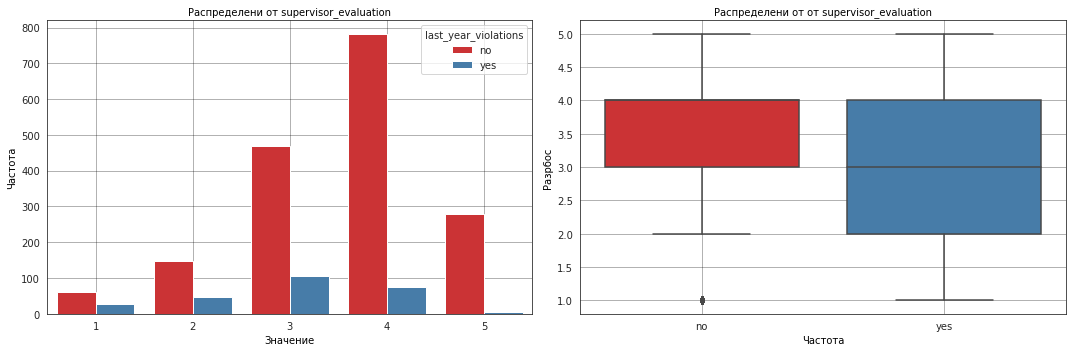

In [38]:
for dis in box_discrete:
    for cat in box_categorical:
        graf_job(df=test_features, hue=cat, x=dis, num=1)

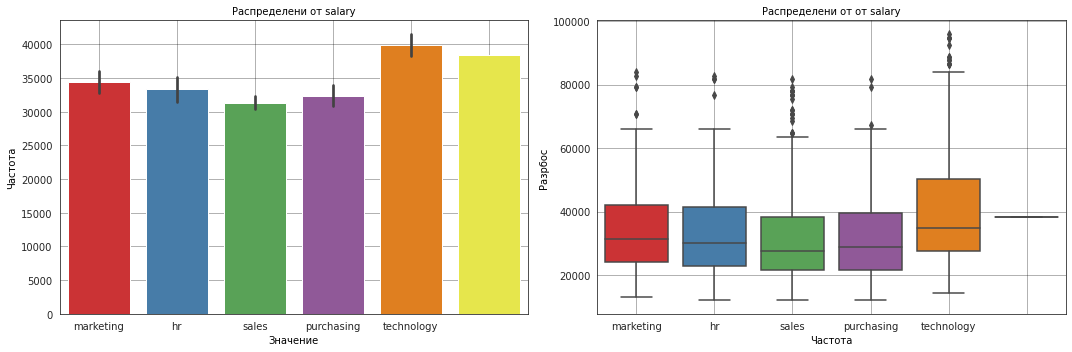

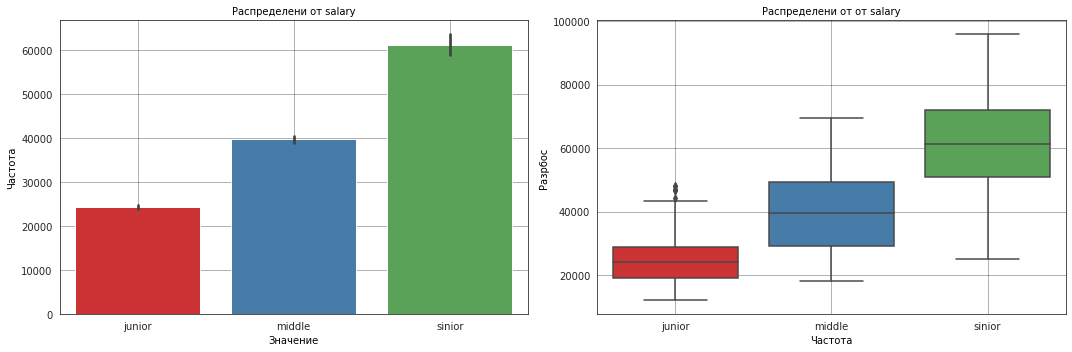

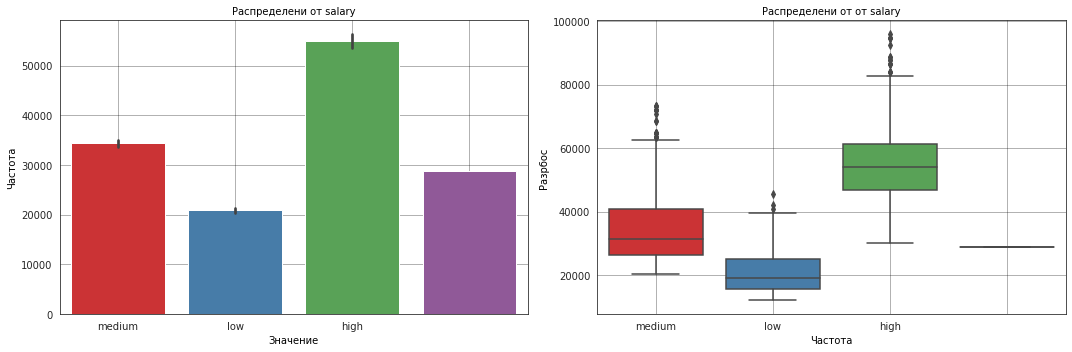

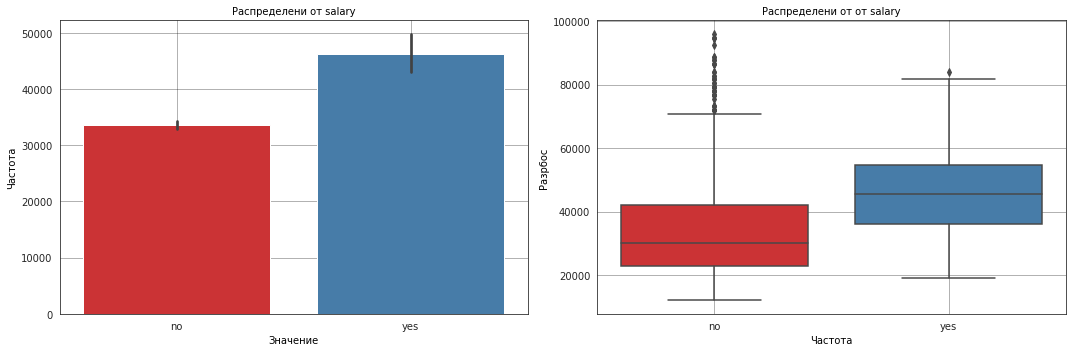

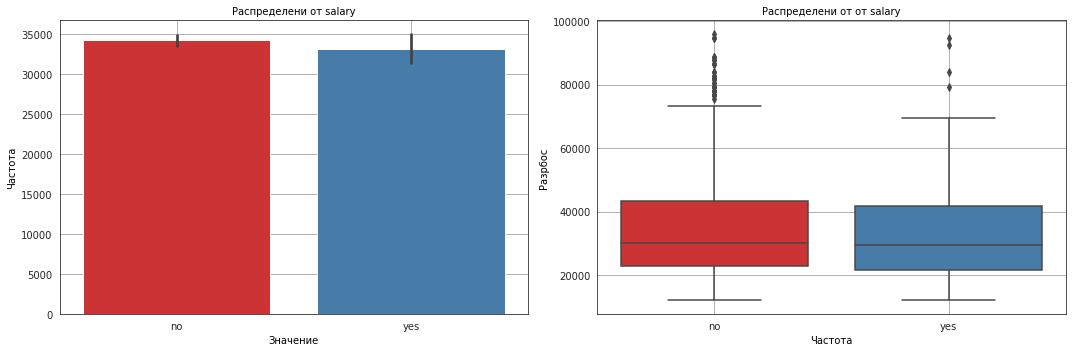

In [39]:
for dis in box_continuously:
    for cat in box_categorical:
        graf_job(df=test_features, hue=cat, x=dis, num=0)

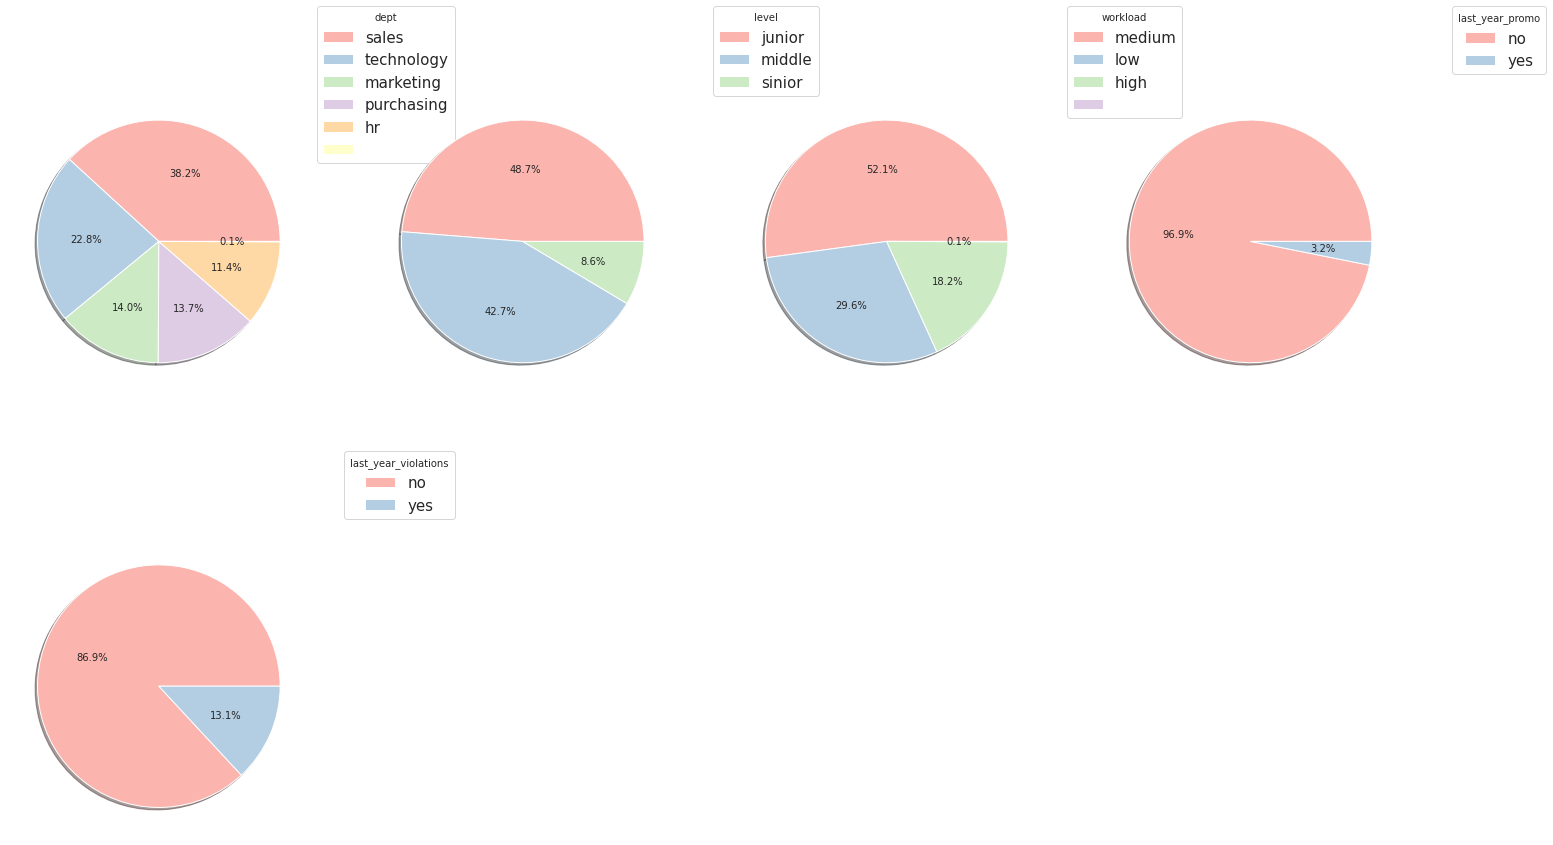

In [40]:
box = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

i = 0


plt.figure(figsize=(25, 15))

for name in box:
    graf_pie(df=test_features, lis=name, i=i)
    i += 1

In [41]:
box_df = test_features

box_df['level'] = box_df['level'].fillna('middle')
box_df['dept'] = box_df['dept'].fillna('sales')

box_df.loc[box_df['dept'] == ' ', 'dept'] = 'sales'

In [42]:
fig = px.sunburst(box_df, 
                  path=['dept', 'level', 'workload'],
                  values='salary',
                  title='График разбивка по специальности и уровню',
                  color_continuous_scale='RdBu'
                 )

fig.show()

В тестовой выборке, все тоже самое как и в основной.

# Целевой признак тестовой выборки

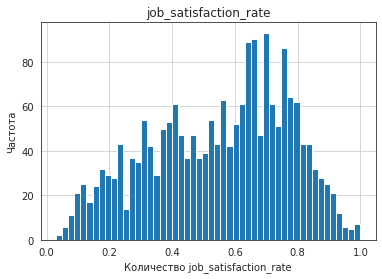

In [43]:
box = ['job_satisfaction_rate']

for name in box:
    func_hist(df=test_target, name=name)

In [45]:
test_target.describe().T

count          mean            std        min  \
id                     2000.0  552765.21350  253851.326129  100298.00   
job_satisfaction_rate  2000.0       0.54878       0.220110       0.03   

                             25%        50%        75%       max  
id                     339052.00  550793.00  765763.75  999029.0  
job_satisfaction_rate       0.38       0.58       0.72       1.0

- Можно заметить на графике длительность работы от професии, большинство hr не задерживаются дольше трех лет.
- Sales работает больше всего они работают до 5 лет.
- У остальных одинаковая тенденция до 5 лет снижение, а потом некоторе плато.

- В редких случаях джуниоры работают до 5 лет без повышения.
- В первый три года работы либо средний уровень нагруженности или низкий, большинство отметили, что у них средний уровень нагруженности. После трех лет нагруженность работы возрастает.

- По нарушениям правил можно заметить, что не нарушают большинство в первые три кода, возможно это связано с боязню потерять работу. Люди нарушают правило с увеличением рабочего опыта чаще, потому что людей с опыт работы более трех лет меньше становится, а нарушений нет.

- Как и ожидалось, те кто доволен работой остаются на ней более трех лет.
- Остальные увольяются в первые три года, потом видно, что недовольствие снижается.

- Распределение оценок от категории работы у всех распределен одинаково. Нужно учитывать, что sale больше всех и поэтому кажется, что выбивается.
- От должности тоже все равномерно, только возможно sinior реже ругаются.
- Из интересного можно заметить, что кто имеет высокие оценки 4 и 5, имеют высокое настроение.

- По зарплате можно заметить, что больше всех в професии зарабатывают technology. У них можно заметить, что зарплата, чаще всего выбивается.
- Sinior получают больше всего.
- Видно что зарплата зависит от нагруженности, чем больше работы, тем больше зарплата.
- При повышении в должности, выростает зарплата, а вот зарплата от правонарушений не зависит.
- На настроение не было видно зависимости зарплаты.

Мини вывод: 

- Можно заметить, что большинство удовлетворены работой.
- Повышение в должности повышает настроение работника.
- Те кто не нарушают правила на работе, удовлетворены работой. Я думаю, те кто нарушают, уже не боятся уволнения.
- От уровня сложности страдают маркетинг и hr на начальных позициях. Там сильнее всего заметно, уровень счастья от кол-во работы и професии.
- На удовлетворенность не замечена влияние зарплаты.
- И здесь спорный момент, тех кого хвалят начальство удовлетворены профессий или им нравится сама работа или им нравится похвала начальства.
- Данные все схожи.

## Корреляционный анализ

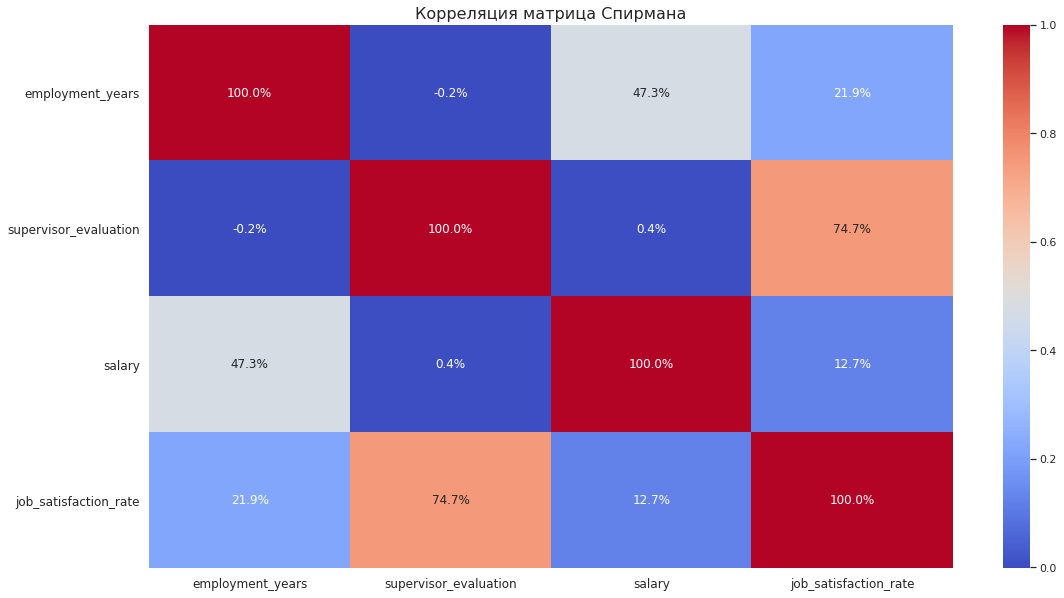

In [46]:
df = train_job.drop(['id'], axis=1)

sns.set(rc={"figure.figsize": (18, 10)})
ax = sns.heatmap(df.corr(method='spearman'), annot=True, fmt='.1%', cmap="coolwarm")

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelrotation=0, labelsize=12)


plt.title('Корреляция матрица Спирмана', fontsize=16);

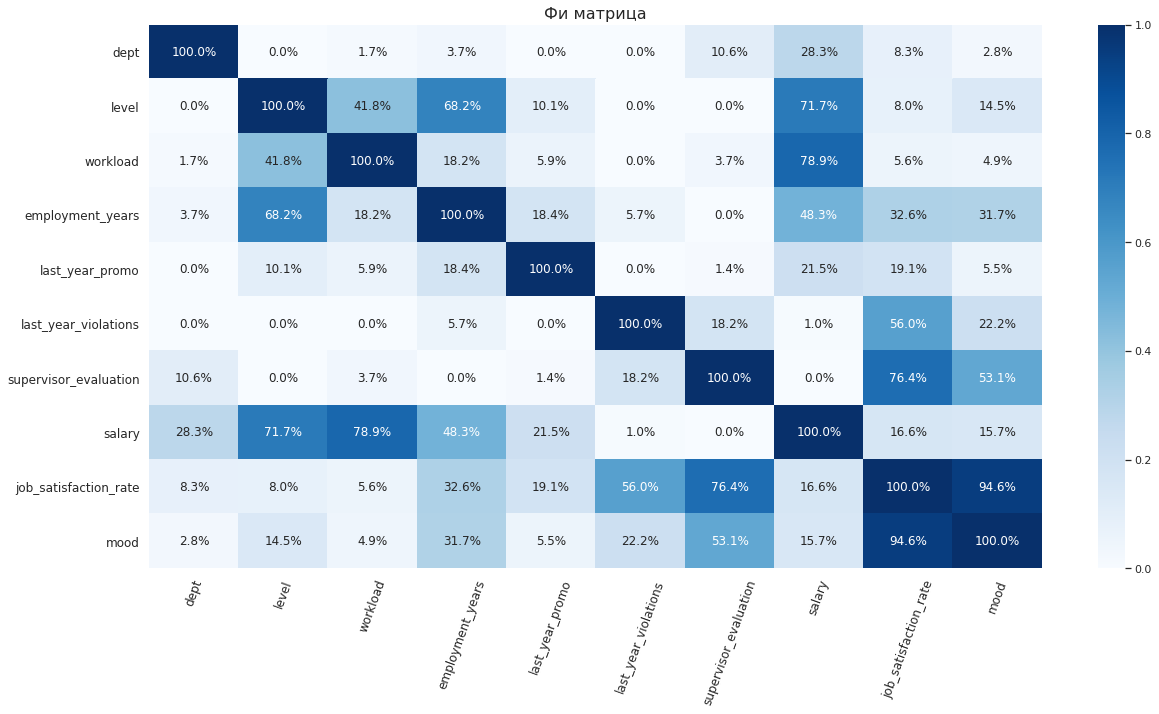

In [47]:
sns.set(rc={"figure.figsize": (20, 10)})
ax = sns.heatmap(df.phik_matrix(interval_cols=['salary', 'job_satisfaction_rate']), annot=True, fmt='.1%', cmap="Blues")

ax.tick_params(axis='x', labelrotation=70, labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.title('Фи матрица', fontsize=16);

- Корреляционая зависимость замечена между опытом работы и зарплатой 47,3%
- А удовлетворенность зависит от оценки руководителя 74%
- По фи можно заметить, что влияет от нарушений есть зависимость 56%
- От длительности работы в компании 32,6%
- От оценки начальника 76,4%

## Подготовка данных

In [48]:
test_features = test_features.sort_values(by='id').reset_index(drop=True)

In [49]:
test_target = test_target.sort_values(by='id').reset_index(drop=True)

In [50]:
train_job = train_job.drop('id', axis=1)
train_job.duplicated().sum()

245

In [51]:
train_job = train_job.drop_duplicates()
train_job.duplicated().sum()

0

In [52]:
X_train = train_job.drop(['job_satisfaction_rate', 'mood'], axis=1)
y_train = train_job['job_satisfaction_rate']
X_test = test_features.drop(['id'], axis=1)
y_test = test_target['job_satisfaction_rate']

In [53]:
ord_columns = ['level', 'workload']
ohe_columns = ['last_year_violations', 'last_year_promo', 'dept']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary'] 

In [54]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', 
         SimpleImputer(missing_values=np.nan, strategy='most_frequent')), 
        ('ohe', 
         OneHotEncoder(drop='first', sparse=False))
    ]
)

In [55]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'], 
                    ['low', 'medium', 'high'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [56]:
data_preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [57]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [58]:
param_grid = [
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [50, 100, 200],
        'models__max_depth': [None, 10, 20],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 21),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    }
]

In [59]:
def SMAPE(y_test, y_pred):
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)
    return (100/len(y_test)) * np.sum((2 * abs(y_test-y_pred)) / (abs(y_test) + abs(y_pred)))

shape_score = make_scorer(SMAPE, greater_is_better=False)

In [60]:
warnings.filterwarnings("ignore")

grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5, 
    scoring=shape_score,  
    n_jobs=-1, 
)

grid.fit(X_train, y_train);

print('Лучшая модель и её параметры:\n', grid.best_params_)
print('Метрика SMAPE для лучшей модели:', round(-grid.best_score_, 3))

Лучшая модель и её параметры:
 {'models': RandomForestRegressor(random_state=42), 'models__max_depth': None, 'models__n_estimators': 100, 'preprocessor__num': MinMaxScaler()}
Метрика SMAPE для лучшей модели: 14.153


<div class="alert alert-info"> Модель немного ухудшилась на тренеровочных данных, но с тестовыми справляется хорошо. Прошлая версия Метрика SMAPE для обучающих данных: 13.351. С другой стороны она меньше стала использовать глубину и деревьев для обучения {'models': RandomForestRegressor(max_depth=20, n_estimators=200, random_state=42), 'models__max_depth': 20, 'models__n_estimators': 200, 'preprocessor__num': MinMaxScaler()}</div> 

In [61]:
y_pred = grid.predict(X_test)
print(f'Метрика SMAPE на тестовой выборке: {round(SMAPE(y_test=y_test, y_pred=y_pred), 3)}')

Метрика SMAPE на тестовой выборке: 12.482


На текущем этапе исследования была создана и обучена модель для выявления снижения удовлетворенности работы.
Наилучшие результаты продемонстрировала модель {'models': RandomForestRegressor(random_state=42), 'models__max_depth': None, 'models__n_estimators': 100, 'preprocessor__num': MinMaxScaler()}.

Метрика SMAPE для обучающих данных: 14.153 и метрика SMAPE на тестовой выборке: 12.519.
Задача выполнена как в ТЗ.

Метрика выбрана по потребности заказа.

## Анализ важности признаков

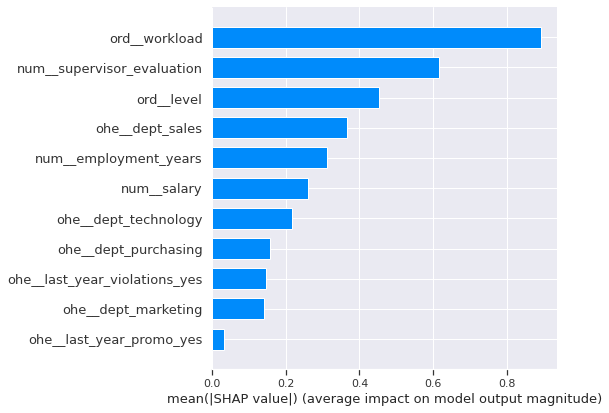

In [62]:
X_encoded = grid.best_estimator_['preprocessor'].fit_transform(X_train)

model = grid.best_estimator_['models'].fit(X_encoded, y_train)
X_test_encoded = grid.best_estimator_['preprocessor'].transform(X_test)

explainer = shap.PermutationExplainer(model, X_encoded)
labels = grid.best_estimator_['preprocessor'].get_feature_names_out()

shap.summary_plot(X_encoded, plot_type='bar', feature_names=labels)

На текущем этапе исследования была создана и обучена модель для выявления снижения удовлетворенности работы.
Наилучшие результаты продемонстрировала модель {'models': RandomForestRegressor(max_depth=20, n_estimators=200, random_state=42), 'models__max_depth': 20, 'models__n_estimators': 200, 'preprocessor__num': MinMaxScaler()}.

Метрика SMAPE для обучающих данных: 13.351 и метрика SMAPE на тестовой выборке: 12.519.
Задача выполнена как в ТЗ.

Наиболее важным признаком оказалсь нагрузка и оценка руководителя.

# Предсказание увольнения сотрудника из компании

## Исследовательский анализ данных 2

# Тренировочная выборка

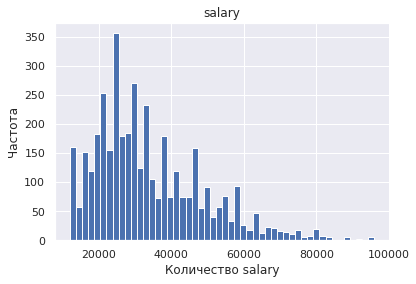

In [63]:
box = ['salary']

for name in box:
    func_hist(df=train_quit, name=name)

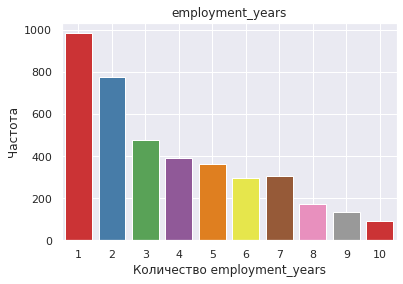

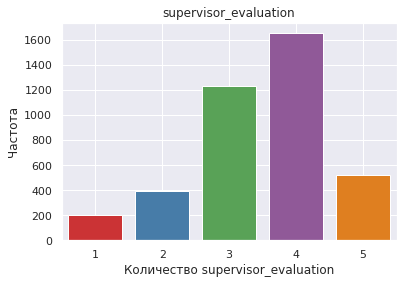

In [64]:
box = ['employment_years', 'supervisor_evaluation']

for name in box:
    func_count(df=train_quit, name=name)

In [65]:
train_quit.describe().T

count          mean            std       min  \
id                     4000.0  552099.28375  260158.031387  100222.0   
employment_years       4000.0       3.70150       2.541852       1.0   
supervisor_evaluation  4000.0       3.47475       1.004049       1.0   
salary                 4000.0   33805.80000   15152.415163   12000.0   

                             25%       50%        75%       max  
id                     327785.75  546673.0  781497.75  999915.0  
employment_years            2.00       3.0       6.00      10.0  
supervisor_evaluation       3.00       4.0       4.00       5.0  
salary                  22800.00   30000.0   43200.00   96000.0

In [66]:
box_discrete = ['employment_years', 'supervisor_evaluation']
box_continuously = ['salary']
box_categorical = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']

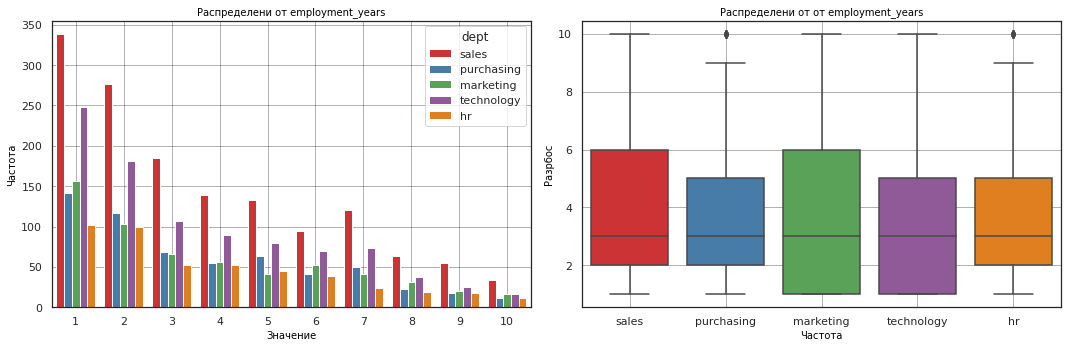

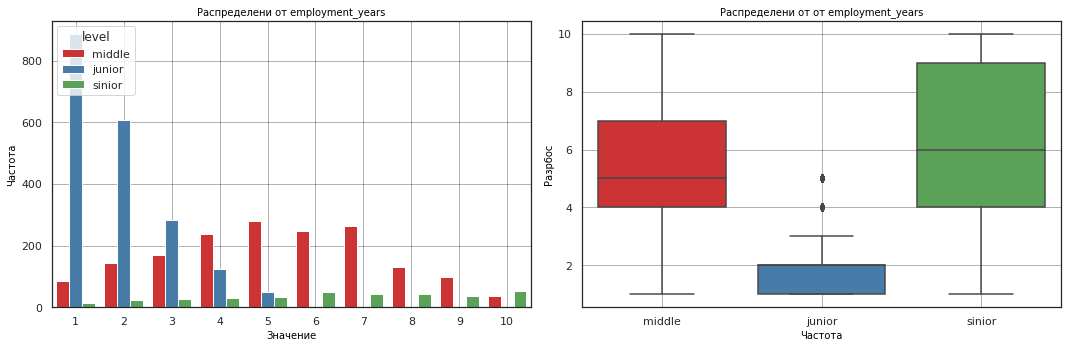

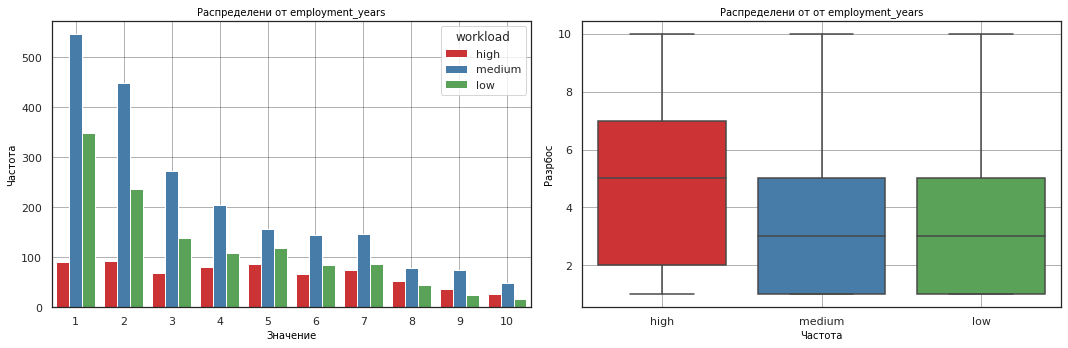

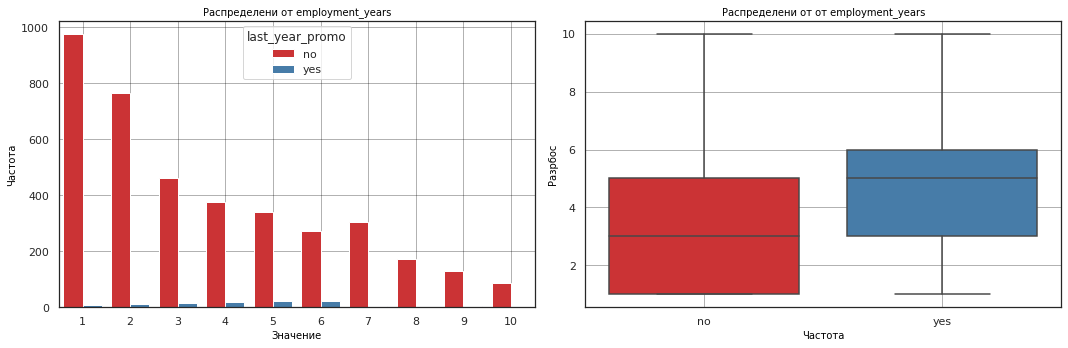

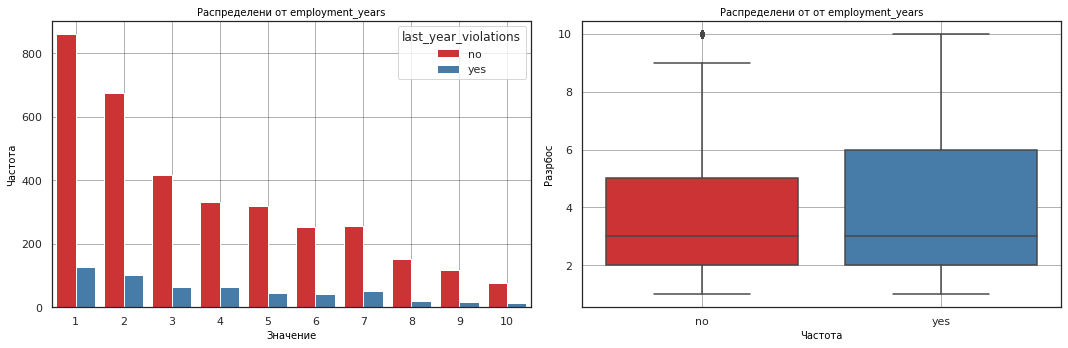

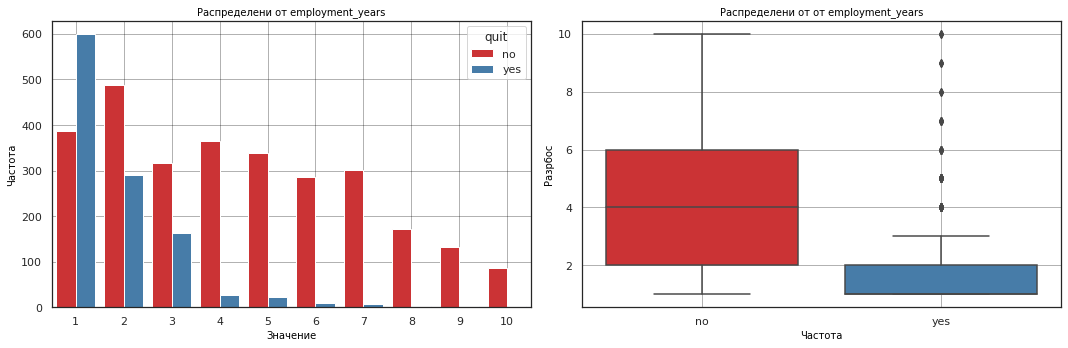

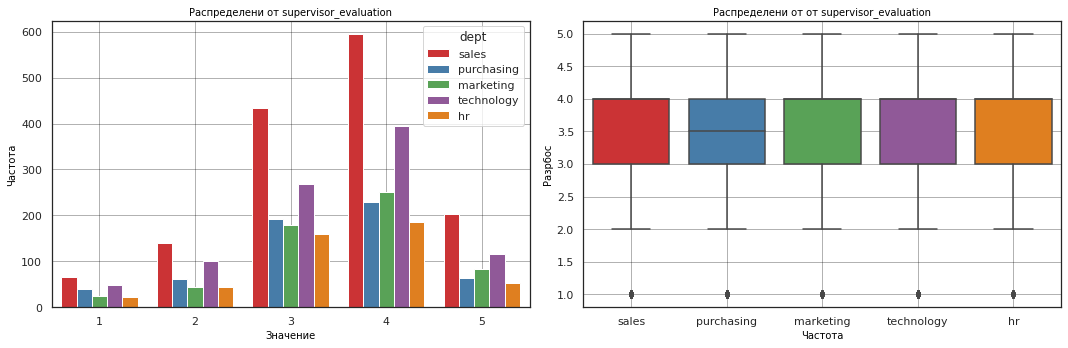

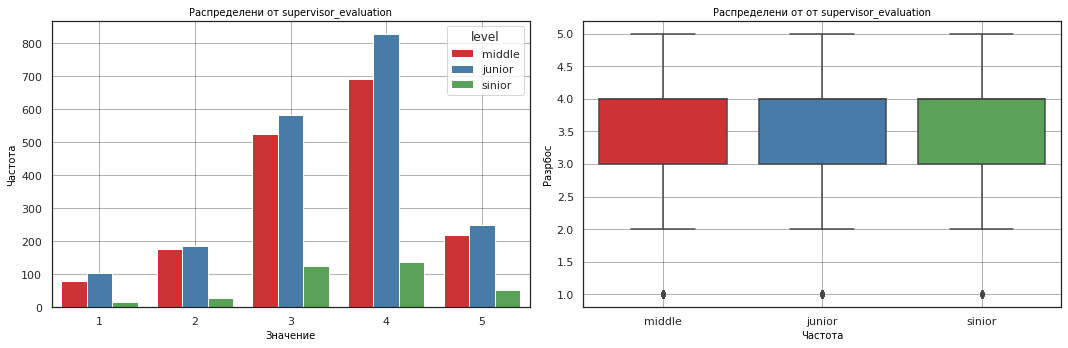

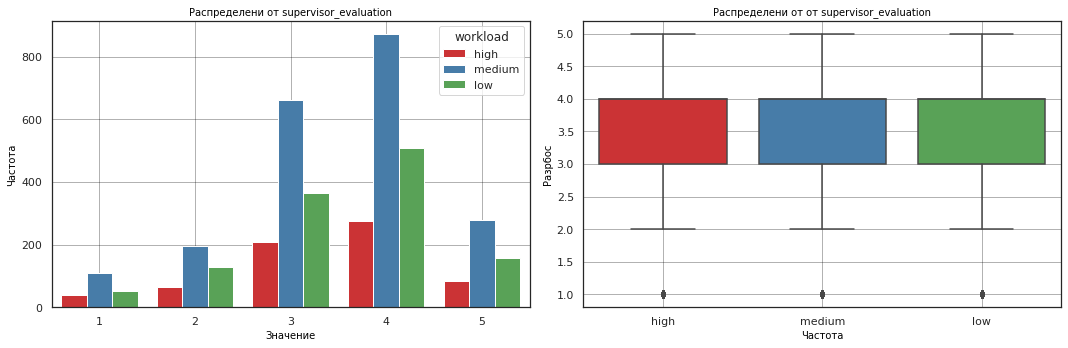

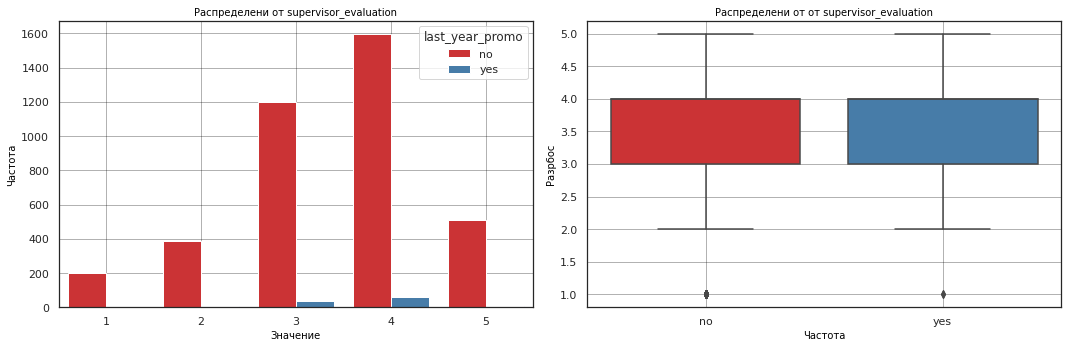

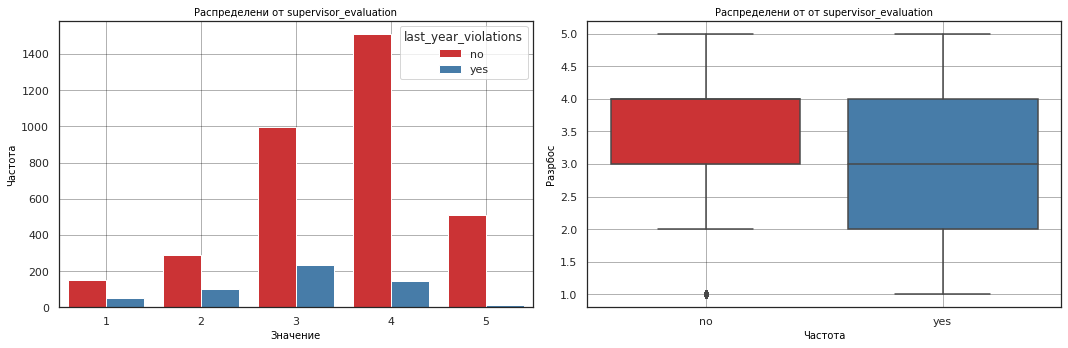

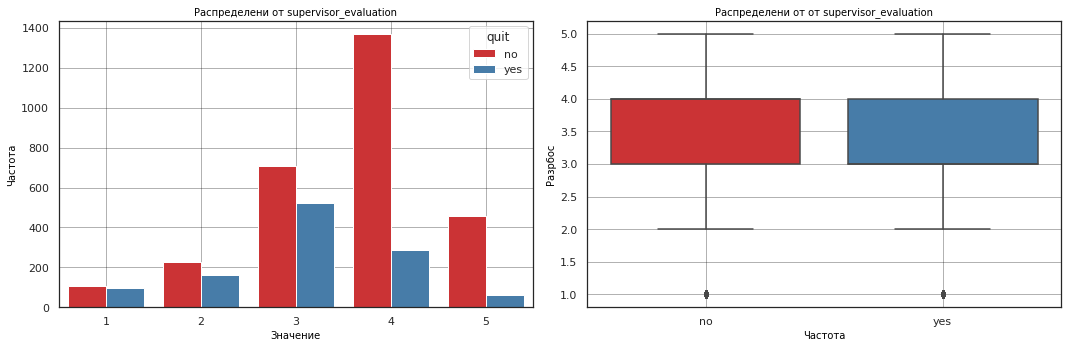

In [67]:
for dis in box_discrete:
    for cat in box_categorical:
        graf_job(df=train_quit, hue=cat, x=dis, num=1)

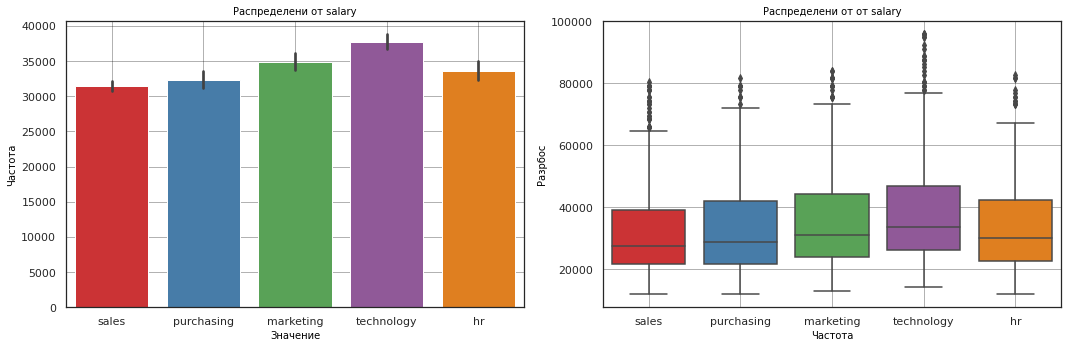

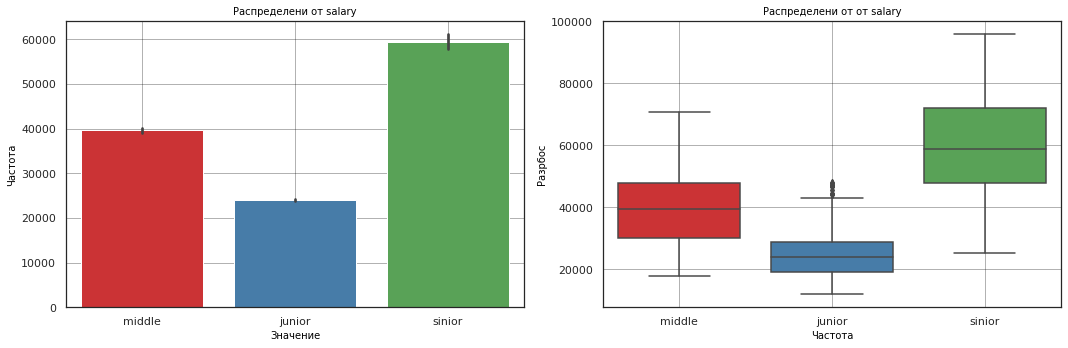

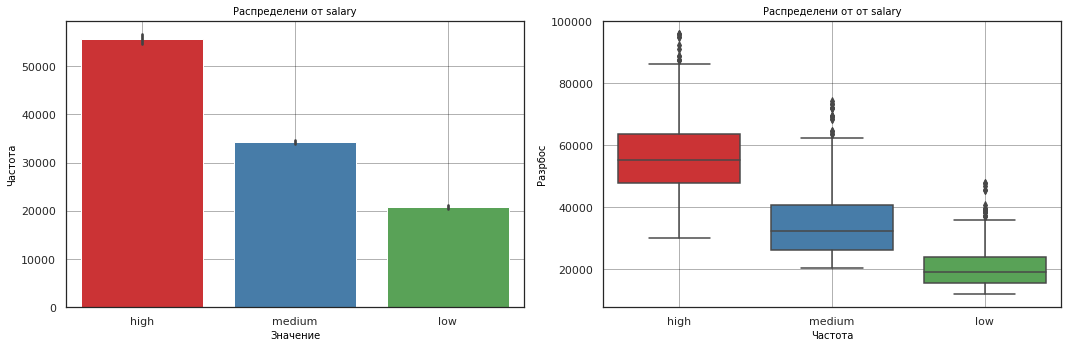

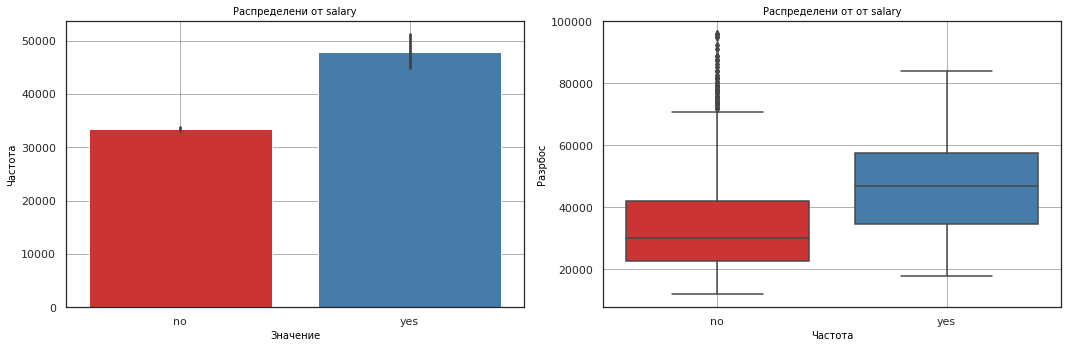

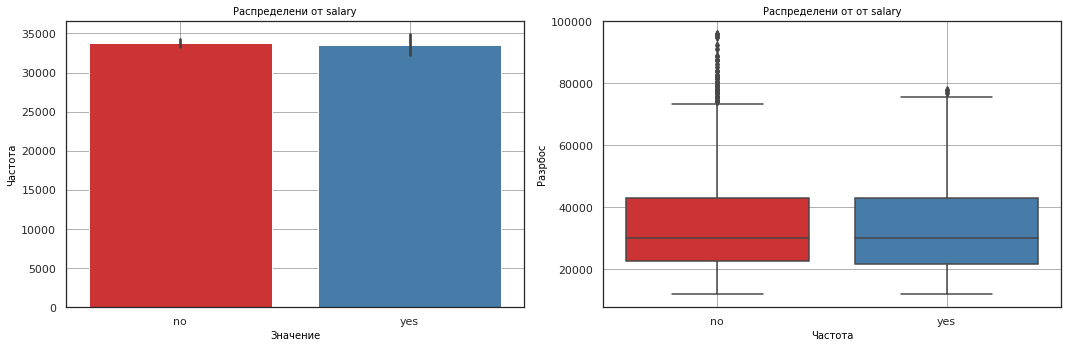

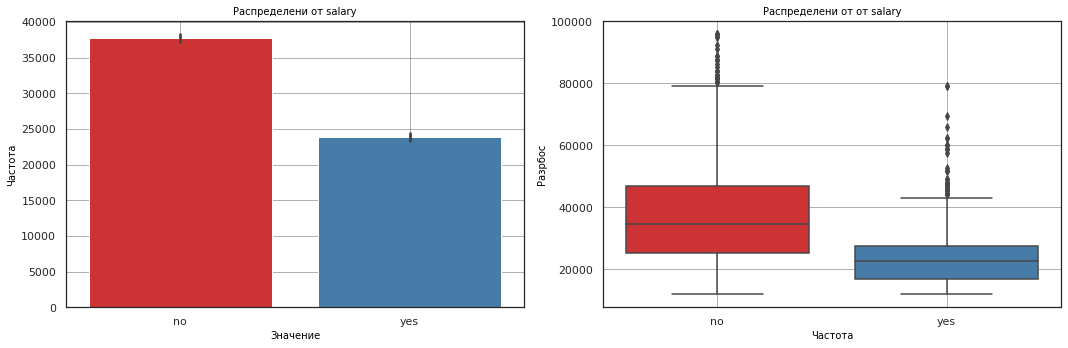

In [68]:
for dis in box_continuously:
    for cat in box_categorical:
        graf_job(df=train_quit, hue=cat, x=dis, num=0)

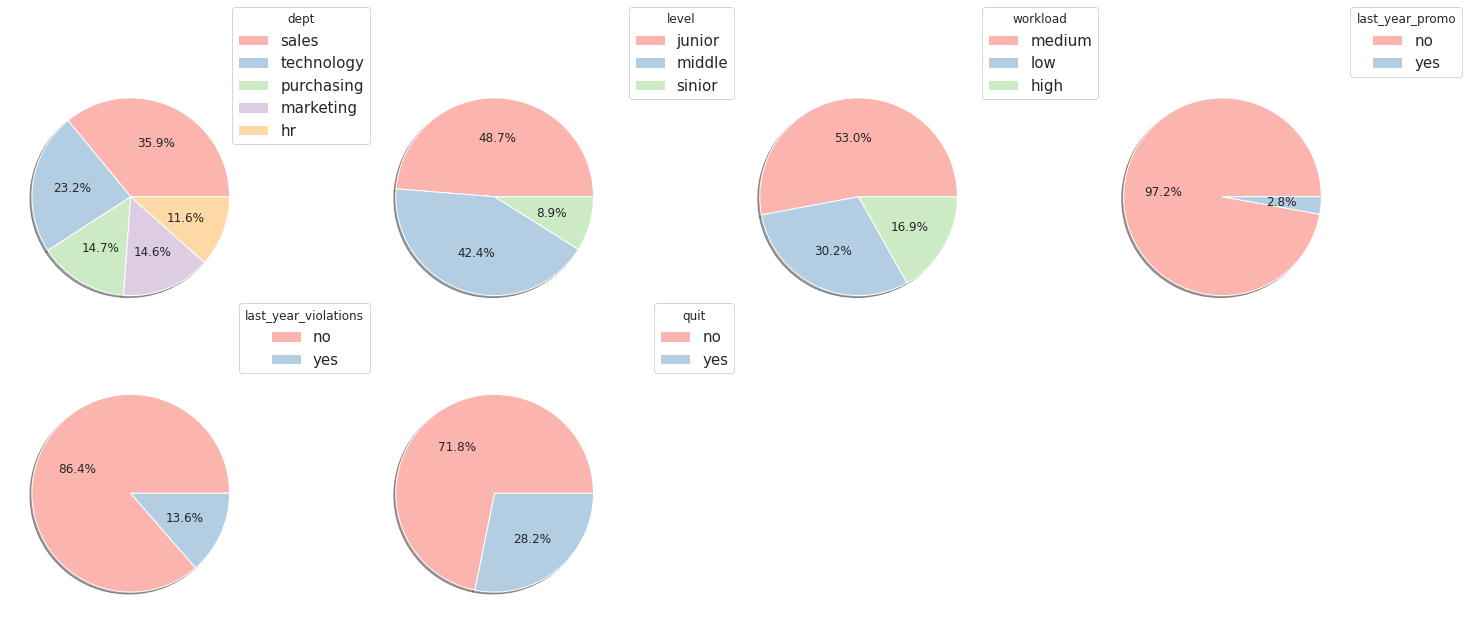

In [69]:
box = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']

i = 0

plt.figure(figsize=(25, 10))

for name in box:
    graf_pie(df=train_quit, lis=name,  i=i)
    i += 1

In [70]:
fig = px.sunburst(train_quit, 
                  path=['dept', 'level', 'workload'],
                  values='salary',
                  title='График разбивка по специальности и уровню',
                  #color='quit',
                  color_continuous_scale='RdBu'
                 )

fig.show()

In [71]:
fig = px.sunburst(train_quit, 
                  path=['dept','level','quit'],
                  values='salary',
                  title='График разбивка по професии и уволнению',
                  color='quit',
                  color_continuous_scale='RdBu'
                 )

fig.show()

In [72]:
fig = px.sunburst(train_quit, 
                  path=['dept','level', 'workload','quit'],
                  values='salary',
                  title='График разбивка по загруженности и уволнению',
                  color='quit',
                  color_continuous_scale='RdBu'
                 )

fig.show()

In [73]:
fig = px.sunburst(train_quit, 
                  path=['dept', 'level', 'last_year_violations', 'quit'],
                  values='salary',
                  title='График разбивка по нарушениям и уволнению',
                  color='quit',
                  color_continuous_scale='RdBu'
                 )

fig.show()

- Увольняются в первые три года сотрудники.
- Опять можно заметить закономерность, уольняются от оценки, чем выше оценки тем меньше увольняются.
- Можно заметить, что чаще всего уходят джунеры, заодно становится понятно, почему в первые три года и уходят.
- Те кто уольняются, не нарушали правила на работе, а те кто нарушает, не увольяняются.

# Целевой признак тестовой выборки

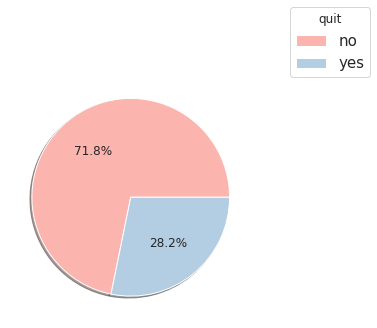

In [74]:
box = ['quit']

i = 0

plt.figure(figsize=(25, 10))

for name in box:
    graf_pie(df=test_target_quit, lis=name,  i=i)
    i += 1

In [75]:
print('Средняя зарплата у уволившихся сотрудников:', round(train_quit.query('quit == "yes"')['salary'].mean(), 0))
print('Средняя зарплата у оставшихся сотрудников:', round(train_quit.query('quit != "yes"')['salary'].mean(), 0))

Средняя зарплата у уволившихся сотрудников: 23885.0
Средняя зарплата у оставшихся сотрудников: 37702.0


- Те кто остаются, имеют больше зарплату.

In [76]:
X_test_2 = test_features.merge(test_target, on='id', how='left').merge(test_target_quit, on='id', how='left')
len(X_test_2)

2000

In [77]:
X_test_2.head(3)

id        dept   level workload  employment_years last_year_promo  \
0  100298          hr  junior      low                 2              no   
1  100480   marketing  junior      low                 4              no   
2  100503  purchasing  middle     high                 5              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  \
0                   no                      4   19200                   0.80   
1                   no                      4   16800                   0.84   
2                   no                      4   55200                   0.79   

  quit  
0   no  
1   no  
2   no

In [78]:
box_discrete = ['employment_years', 'supervisor_evaluation']
box_continuously = ['salary', 'job_satisfaction_rate']
box_categorical = [ 'quit']

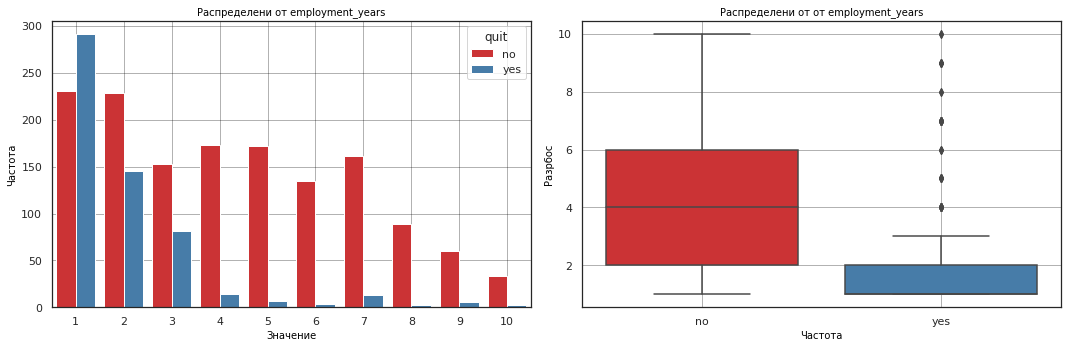

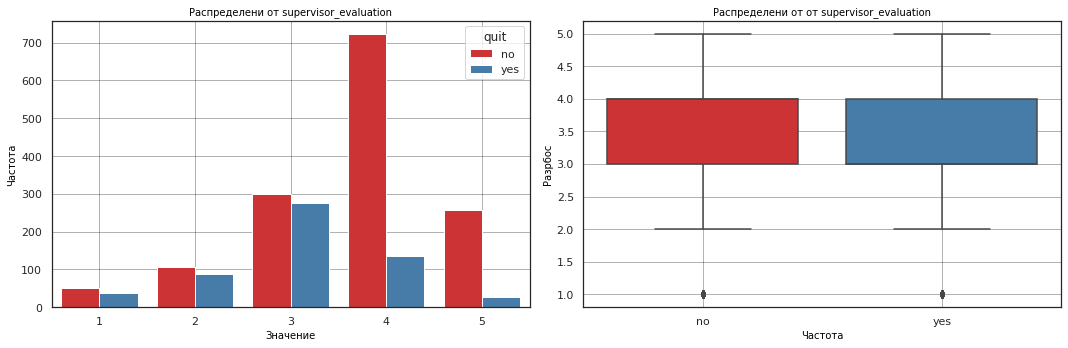

In [79]:
for dis in box_discrete:
    for cat in box_categorical:
        graf_job(df=X_test_2, hue=cat, x=dis, num=1)

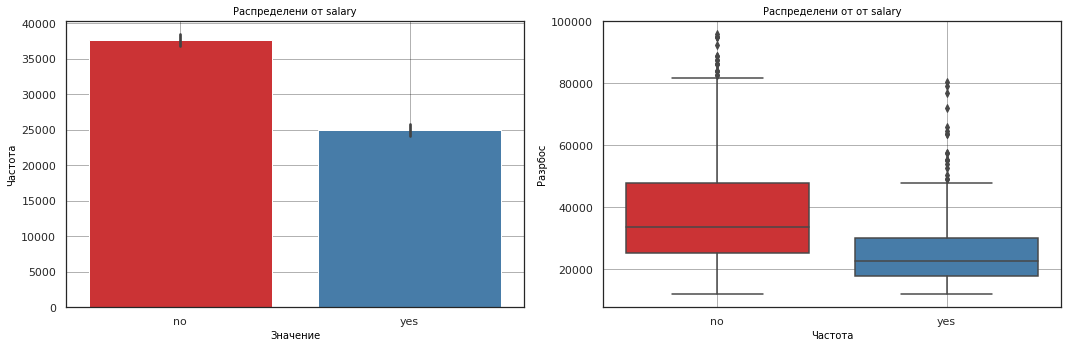

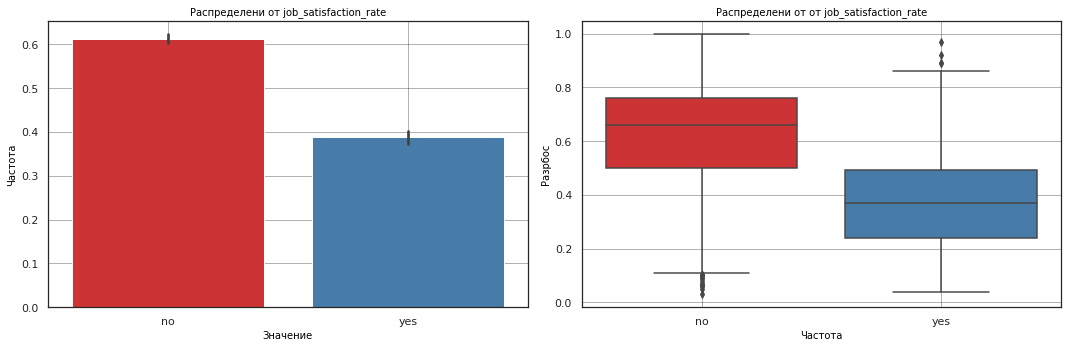

In [80]:
for dis in box_continuously:
    for cat in box_categorical:
        graf_job(df=X_test_2, hue=cat, x=dis, num=0)

- Увольняются в первые три года сотрудники.
- Опять можно заметить закономерность, уольняются от оценки, чем выше оценки тем меньше увольняются.
- Можно заметить, что чаще всего уходят джунеры, заодно становится понятно, почему в первые три года и уходят.
- Те кто уольняются, не нарушали правила на работе, а те кто нарушает, не увольяняются.
- Те кто остаются, имеют больше зарплату.

## Корреляционный анализ 2

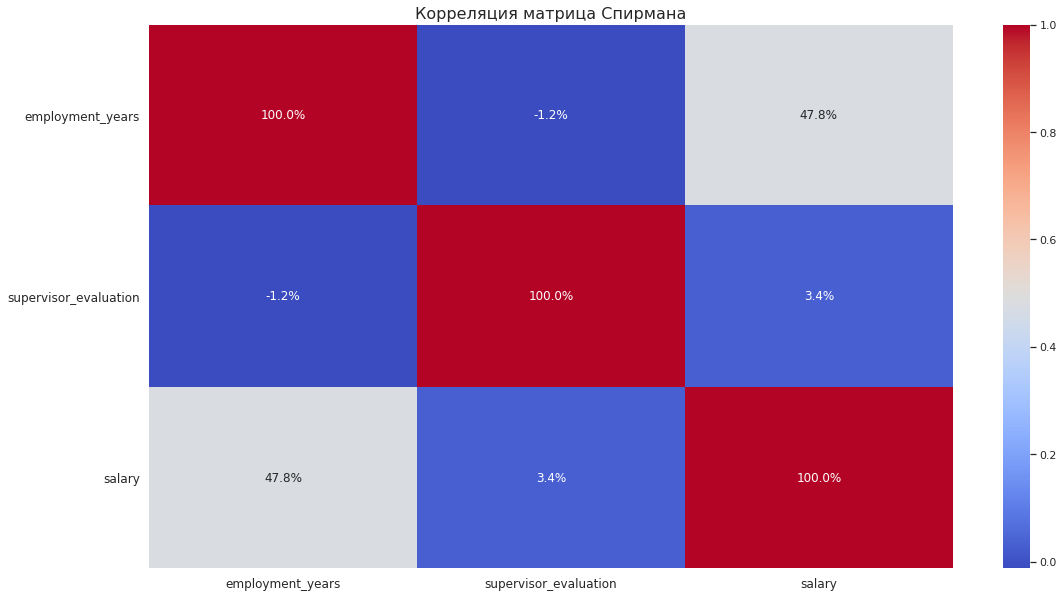

In [81]:
df = train_quit.drop(['id'], axis=1)

sns.set(rc={"figure.figsize": (18, 10)})
ax = sns.heatmap(df.corr(method='spearman'), annot=True, fmt='.1%', cmap="coolwarm")

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelrotation=0, labelsize=12)


plt.title('Корреляция матрица Спирмана', fontsize=16);

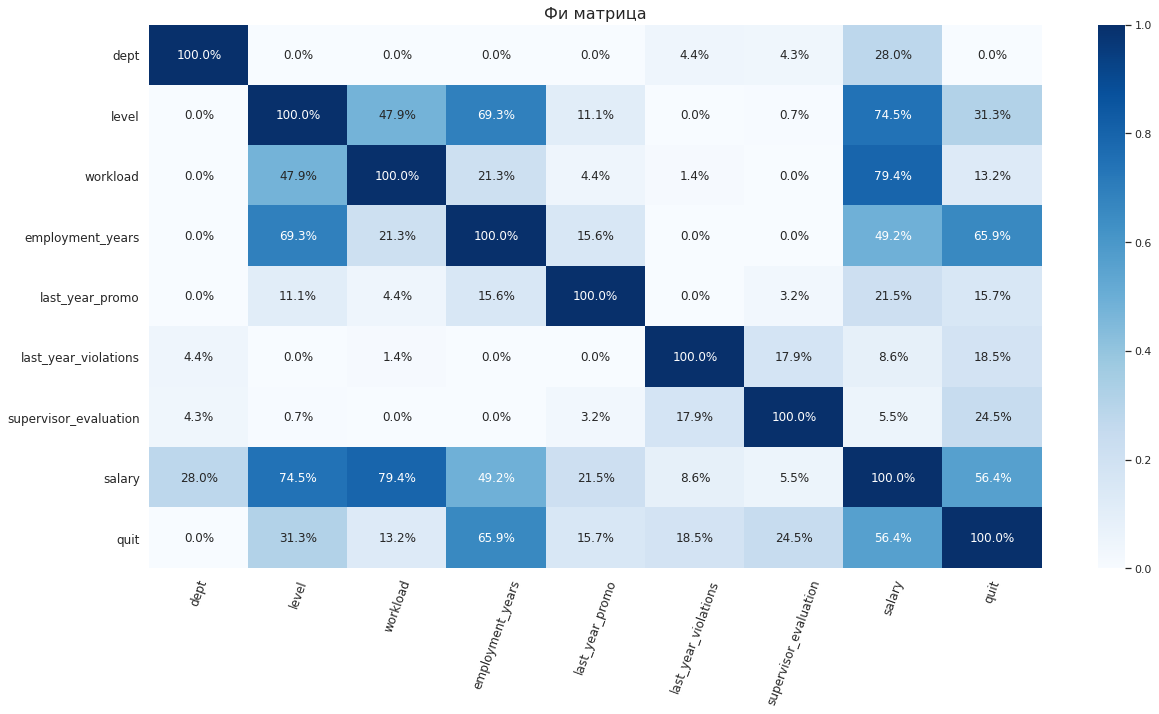

In [82]:
sns.set(rc={"figure.figsize": (20, 10)})
ax = sns.heatmap(df.phik_matrix(interval_cols=['salary', 'job_satisfaction_rate']), annot=True, fmt='.1%', cmap="Blues")

ax.tick_params(axis='x', labelrotation=70, labelsize=12)
ax.tick_params(axis='y', labelsize=12)

plt.title('Фи матрица', fontsize=16);

## Гипотеза

In [83]:
# H0: уровень удовлетворённости работой не отличается между сотрудниками, которые уволились, и теми, кто не уволился.
# H1: уровень удовлетворённости работой отличается между сотрудниками, которые уволились, и теми, кто не уволился.

alpha = 0.05 

results = st.ttest_ind(X_test_2.query('quit == "no"')['job_satisfaction_rate'], X_test_2.query('quit == "yes"')['job_satisfaction_rate'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.231122066517193e-104
Отвергаем нулевую гипотезу


- Удовлетворенность работы влияет на увольнение.

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Отлично!!!! Составлен портрет «ушедшего работника», также есть визуализация и сравнение распределений признака job_satisfaction_rate для ушедших и оставшихся работников, плюс сравнение со стат тестом, "строго".
</div>

## Обучение Модели

In [84]:
X_test_2 = X_test_2.sort_values(by='id')
train_quit = train_quit.sort_values(by='id')
test_target_quit = test_target_quit.sort_values(by='id')

In [85]:
train_quit_2 = train_quit.drop(columns='id')
train_quit_2.duplicated().sum()

1413

In [86]:
train_quit_2 = train_quit_2.drop_duplicates()
train_quit_2.duplicated().sum()

0

In [87]:
box = train_quit_2.drop(['quit'], axis=1)
y_pred = grid.predict(box)

train_quit_2['job_satisfaction_rate'] = y_pred

In [88]:
train_quit_2.head(5)

dept   level workload  employment_years last_year_promo  \
2600       sales  junior   medium                 3              no   
717   purchasing  junior   medium                 3              no   
2455   marketing  junior   medium                 1              no   
1592  technology  middle     high                 4              no   
2657       sales  junior   medium                 2              no   

     last_year_violations  supervisor_evaluation  salary quit  \
2600                   no                      2   20400  yes   
717                    no                      3   21600  yes   
2455                   no                      4   28800   no   
1592                   no                      4   68400   no   
2657                   no                      4   25200  yes   

      job_satisfaction_rate  
2600               0.340967  
717                0.335669  
2455               0.641797  
1592               0.670169  
2657               0.842235

In [89]:
box = X_test_2.drop(['quit'], axis=1)
y_pred = grid.predict(box)

X_test_2['job_satisfaction_rate'] = y_pred

In [90]:
X_test_2.head(5)

id        dept   level workload  employment_years last_year_promo  \
0  100298          hr  junior      low                 2              no   
1  100480   marketing  junior      low                 4              no   
2  100503  purchasing  middle     high                 5              no   
3  100610       sales  middle   medium                 5              no   
4  100692       sales  middle     high                 6              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  \
0                   no                      4   19200               0.829010   
1                   no                      4   16800               0.841901   
2                   no                      4   55200               0.771515   
3                   no                      4   43200               0.812470   
4                   no                      4   48000               0.703861   

  quit  
0   no  
1   no  
2   no  
3   no  
4   no

Было доказано, что удовлетворенность влияет на работу, поэтому мы добавим новую колонку, удовлетворенность для предсказания увольнения.

In [91]:
X_train = train_quit_2.drop(['quit'], axis=1)
y_train = train_quit_2['quit']
X_test = X_test_2.drop(['id', 'quit'], axis=1)
y_test = test_target_quit['quit']

In [92]:
label_encoder = LabelEncoder()
y_train_ = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
label_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))

In [93]:
label_mapping

{0: 'no', 1: 'yes'}

In [94]:
ord_columns = ['level', 'workload']
ohe_columns = ['last_year_violations', 'last_year_promo', 'dept']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate'] 

In [95]:
param_grid = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [96]:
warnings.filterwarnings("ignore")

grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5, 
    scoring='roc_auc',  
    n_jobs=-1, 
)

grid.fit(X_train, y_train);

print('Лучшая модель и её параметры:\n', grid.best_params_)
print('Метрика ROC-AUC для лучшей модели:', round(grid.best_score_, 3))

Лучшая модель и её параметры:
 {'models': DecisionTreeClassifier(max_depth=4, random_state=42), 'models__max_depth': 4, 'preprocessor__num': StandardScaler()}
Метрика ROC-AUC для лучшей модели: 0.904


In [97]:
y_pred = grid.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_pred[:, 1]), 3)}')

Метрика ROC-AUC на тестовой выборке: 0.916


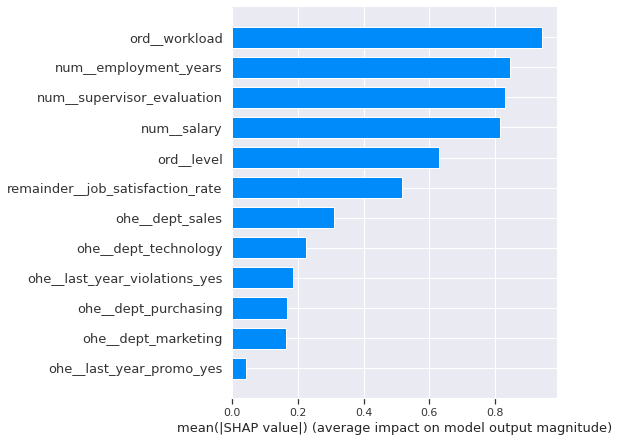

In [98]:
X_encoded = grid.best_estimator_['preprocessor'].fit_transform(X_train)

model = grid.best_estimator_['models'].fit(X_encoded, y_train)
X_test_encoded = grid.best_estimator_['preprocessor'].transform(X_test)

explainer = shap.PermutationExplainer(model, X_encoded)
labels = grid.best_estimator_['preprocessor'].get_feature_names_out()

shap.summary_plot(X_encoded, plot_type='bar', feature_names=labels)

На текущем этапе исследования была создана и обучена модель для выявления снижения удовлетворенности работы.
Наилучшие результаты продемонстрировала модель {'models': SVC(probability=True, random_state=42), 'preprocessor__num': MinMaxScaler()}.

Метрика ROC-AUC для лучшей модели: 0.93 и Метрика ROC-AUC на тестовой выборке: 0.922.
Задача выполнена как в ТЗ.

Наиболее важным признаком оказалсь нагрузка и оценка руководителя и уровень удовлетворённости сотрудника.

## Вывод

Добрый день, коллеги.
Я сделал работу от «Работа с заботой».
Я смог сделать МО, чтобы предсказать удовлетворенность от работы и вероятность, что сотрудник уйдет.
Также провел анализ, который может быть полезен для hr.

1) Я обработал данные:

- Явных дубликатов не было найдено.
- Я удалил дубликаты, после того как удалил id.
- Пропуски я заменил на самое распространенные значения.
- df я отсортировал по id.

2) Анализ данных для удовлетворенности:

- Можно заметить, что большинство удовлетворены работой.
- Повышение в должности повышает настроение работника.
- Те кто не нарушают правила на работе, удовлетворены работой. Я думаю, те кто нарушают, уже не боятся уволнения.
- От уровня сложности страдают маркетинг и hr на начальных позициях. Там сильнее всего заметно, уровень счастья от кол-во работы и професии.
- На удовлетворенность не замечена влияние зарплаты.
- И здесь спорный момент, тех кого хвалят начальство удовлетворены профессий или им нравится сама работа или им нравится похвала начальства.

Остальное можно найти в тетрадке.

3) МО для предсказание удовлетворенности:

На текущем этапе исследования была создана и обучена модель для выявления снижения удовлетворенности работы.
Наилучшие результаты продемонстрировала модель {'models': RandomForestRegressor(random_state=42), 'models__max_depth': None, 'models__n_estimators': 100, 'preprocessor__num': MinMaxScaler()}.

Метрика SMAPE для обучающих данных: 14.153 и метрика SMAPE на тестовой выборке: 12.519.
Задача выполнена как в ТЗ.

Наиболее важным признаком оказалсь нагрузка и оценка руководителя.

4) Анализ данных на увольнение:

- Увольняются в первые три года сотрудники.
- Опять можно заметить закономерность, уольняются от оценки, чем выше оценки тем меньше увольняются.
- Можно заметить, что чаще всего уходят джунеры, заодно становится понятно, почему в первые три года и уходят.
- Те кто уольняются, не нарушали правила на работе, а те кто нарушает, не увольяняются.

5) Гипотеза:

- В гипотезе я доказал, что удовлетворенность работы влияет на увольнение.

6) МО для предсказания увольнения:

На текущем этапе исследования была создана и обучена модель для выявления снижения удовлетворенности работы.
Наилучшие результаты продемонстрировала модель {'models': SVC(probability=True, random_state=42), 'preprocessor__num': MinMaxScaler()}.

Метрика ROC-AUC для лучшей модели: 0.93 и Метрика ROC-AUC на тестовой выборке: 0.922.
Задача выполнена как в ТЗ.

Наиболее важным признаком оказалсь нагрузка и оценка руководителя и уровень удовлетворённости сотрудника.